In [1]:
# facenet_pytorch_c: avoid confusion with system default facenet_pytorch
#from facenet_pytorch_c import MTCNN

from tqdm import tqdm
import numpy as np
import os

# pytorch
import torch
import torch.optim as optim
from torch import nn

# data handling
from torch.utils.data import DataLoader

# torchvision libs
import torchvision
from torchvision import datasets
from torchvision import transforms
import PIL

import utils_pnet as utils


In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Available device: " + str(device))

# training hyperparameters
learning_rate = 1e-3
epochs = 200
decay_step = [100, 150]
decay_rate = 0.1
opt = 'Adam'    # either Adam or SGD
batch_size = 64

# data loading parameters
workers = 4

Available device: cuda:0


In [4]:
x_t, b_prob_t, b_box_t, _, _, x_v, b_prob_v, b_box_v, _, _ = utils.get_images(
    img_path='/home/ubuntu/db_proc/db/images',
    anno_path='/home/ubuntu/db_proc/db/annotations',
    valid_percent=0.1, resize_shape=(48,48),
    add_orig=False, gen_xtra_neg=True, gen_xtra_body=True, gen_xtra_face=False
)

print(len(x_t))
print_freq = int(len(x_t)/batch_size - 5)
print("print freq: {}".format(print_freq))

100%|██████████| 3605/3605 [01:32<00:00, 39.06it/s] 


67554
print freq: 1050


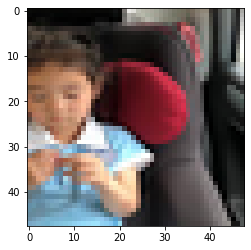

body: [ 0  3 28 48]


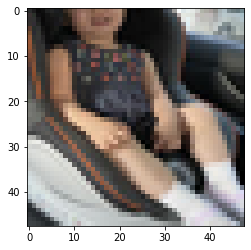

body: [ 0  0 39 35]


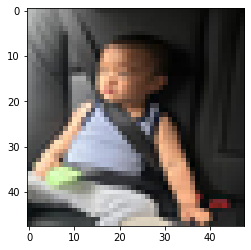

body: [ 0  5 42 48]


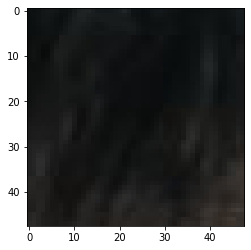

body: [0 0 0 0]


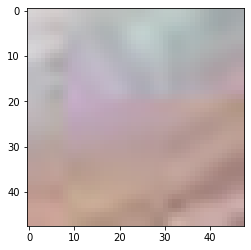

body: [0 0 0 0]


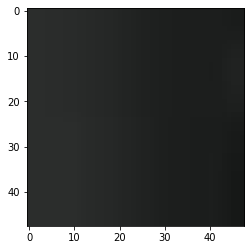

body: [0 0 0 0]


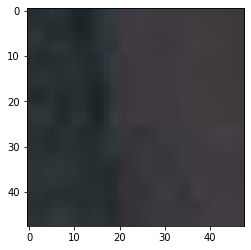

body: [0 0 0 0]


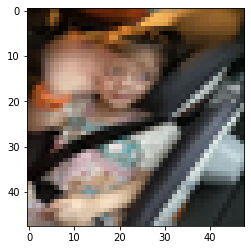

body: [ 0  4 34 48]


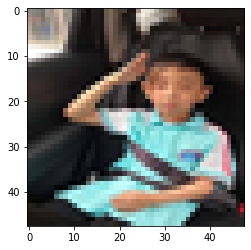

body: [ 8  9 47 48]


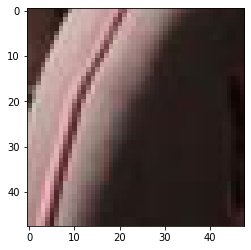

body: [0 0 0 0]


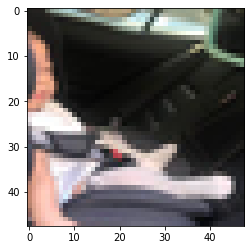

body: [ 0  3 31 48]


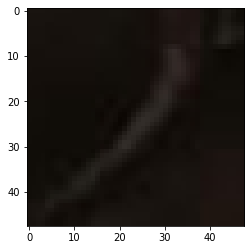

body: [0 0 0 0]


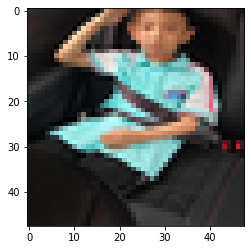

body: [ 6  0 44 33]


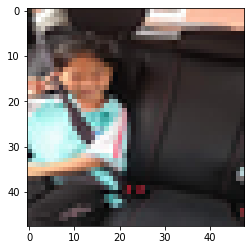

body: [ 0  5 24 40]


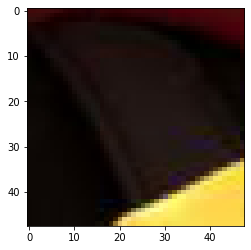

body: [0 0 0 0]


In [5]:

for i in range(0, 300, 20):
    plt.imshow(x_t[i])
    plt.show()
    print("body: {}".format(b_box_t[i]))

In [6]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_ds = utils.CIVDS_bnet(x_t, b_prob_t, b_box_t, trsfm=transform_train)

valid_ds = utils.CIVDS_bnet(x_v, b_prob_v, b_box_v, trsfm=transform_valid)

train_loader = DataLoader(
    train_ds, batch_size=batch_size,
    num_workers=workers, shuffle=True
)

valid_loader = DataLoader(
    valid_ds, batch_size=batch_size,
    num_workers=workers, shuffle=False
)

In [7]:
class BNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.prelu1 = nn.PReLU(32)
        self.pool1 = nn.MaxPool2d(3, 2, ceil_mode=True)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.prelu2 = nn.PReLU(64)
        self.pool2 = nn.MaxPool2d(3, 2, ceil_mode=True)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3)
        self.prelu3 = nn.PReLU(64)
        self.pool3 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=2)
        self.prelu4 = nn.PReLU(128)
        self.dense5 = nn.Linear(1152, 256)
        self.prelu5 = nn.PReLU(256)
        
        self.dense6_1 = nn.Linear(256, 2)    # body prob
        self.softmax6_1 = nn.Softmax(dim=1)
        
        self.dense6_2 = nn.Linear(256, 4)    # body bbox

        self.training = True

    def forward(self, x):
        x = self.conv1(x)
        x = self.prelu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.prelu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.prelu3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.prelu4(x)
        x = self.dense5(x.view(x.shape[0], -1))
        x = self.prelu5(x)
        a = self.dense6_1(x)
        a = self.softmax6_1(a)
        b = self.dense6_2(x)
        return a, b


In [8]:
bnet = BNet()
bnet.train()
bnet.to(device)

BNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (prelu1): PReLU(num_parameters=32)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (prelu2): PReLU(num_parameters=64)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (prelu3): PReLU(num_parameters=64)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv4): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (prelu4): PReLU(num_parameters=128)
  (dense5): Linear(in_features=1152, out_features=256, bias=True)
  (prelu5): PReLU(num_parameters=256)
  (dense6_1): Linear(in_features=256, out_features=2, bias=True)
  (softmax6_1): Softmax(dim=1)
  (dense6_2): Linear(in_features=256, out_features=4, bias=True)
)

In [9]:

from tensorboardX import SummaryWriter

writer = SummaryWriter(log_dir="/home/ubuntu/tensorLog") # tensorboard writer

prob_lossfn = nn.BCELoss().to(device)
bbox_lossfn = nn.MSELoss().to(device)

optimizer = None

if opt == "Adam":
    print("Optimizer: Adam")
    optimizer = torch.optim.Adam(bnet.parameters(), lr=learning_rate, amsgrad=True)
elif opt == "SGD":
    print("Optimizer: SGD")
    optimizer = torch.optim.SGD(bnet.parameters(), lr=learning_rate, momentum=0.9)
else:
    print("Error")

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=decay_step, gamma=decay_rate)

rl1, rl2 = 0, 0

for epoch in range(1, epochs+1):
    
    for batch_idx, data in enumerate(train_loader):
        
        im, b_prob, b_box = data
        
        im = im.to(device)
        b_prob = b_prob.float().to(device)
        b_box = b_box.float().to(device)
        
        o_b_prob, o_b_box = bnet(im)
        
        o_b_prob = o_b_prob.float().squeeze()
        o_b_box = o_b_box.float().squeeze()
        
        b_prob_l = prob_lossfn(o_b_prob, b_prob)
        b_box_l = bbox_lossfn(o_b_box, b_box)
        
        rl1 += b_prob_l.item()
        rl2 += b_box_l.item()

        all_loss = b_prob_l + b_box_l
        
        if batch_idx % print_freq == print_freq-1:
            
            print(
                "ep: {}; bpl: {:.2f}; bbl: {:.2f};".format(
                    epoch, rl1/print_freq, rl2/print_freq
                )
            )
            writer.add_scalar('bpl', rl1/print_freq, epoch)
            writer.add_scalar('bbl', rl2/print_freq, epoch)
            
            rl1, rl2 = 0, 0

        optimizer.zero_grad()
        all_loss.backward()
        optimizer.step()
    
    scheduler.step()

print("finished training")

save_name = 'bnet.pt'
torch.save(bnet.state_dict(), save_name)
print('Saved model at {}'.format(save_name))

Optimizer: Adam
ep: 1; bpl: 0.40; bbl: 71.73;
ep: 2; bpl: 0.35; bbl: 44.97;
ep: 3; bpl: 0.33; bbl: 33.89;
ep: 4; bpl: 0.32; bbl: 27.53;
ep: 5; bpl: 0.31; bbl: 22.08;
ep: 6; bpl: 0.30; bbl: 18.42;
ep: 7; bpl: 0.30; bbl: 15.76;
ep: 8; bpl: 0.29; bbl: 13.11;
ep: 9; bpl: 0.29; bbl: 11.64;
ep: 10; bpl: 0.29; bbl: 10.52;
ep: 11; bpl: 0.29; bbl: 9.67;
ep: 12; bpl: 0.28; bbl: 8.58;
ep: 13; bpl: 0.28; bbl: 7.70;
ep: 14; bpl: 0.28; bbl: 7.16;
ep: 15; bpl: 0.28; bbl: 6.30;
ep: 16; bpl: 0.28; bbl: 5.86;
ep: 17; bpl: 0.28; bbl: 5.44;
ep: 18; bpl: 0.28; bbl: 5.15;
ep: 19; bpl: 0.28; bbl: 4.50;
ep: 20; bpl: 0.28; bbl: 4.38;
ep: 21; bpl: 0.28; bbl: 3.96;
ep: 22; bpl: 0.28; bbl: 3.63;
ep: 23; bpl: 0.28; bbl: 3.77;
ep: 24; bpl: 0.28; bbl: 3.17;
ep: 25; bpl: 0.28; bbl: 2.96;
ep: 26; bpl: 0.28; bbl: 2.82;
ep: 27; bpl: 0.28; bbl: 2.61;
ep: 28; bpl: 0.28; bbl: 2.54;
ep: 29; bpl: 0.28; bbl: 2.41;
ep: 30; bpl: 0.28; bbl: 2.28;
ep: 31; bpl: 0.28; bbl: 2.23;
ep: 32; bpl: 0.28; bbl: 2.07;
ep: 33; bpl: 0.28; bbl:

KeyboardInterrupt: 

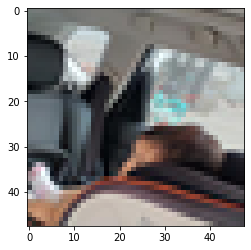

tb: 1; pb: 0.8
body: [ 3. 28. 45. 50.]


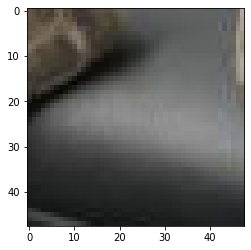

tb: 0; pb: 0.0
body: [ 0. -0. -0.  0.]


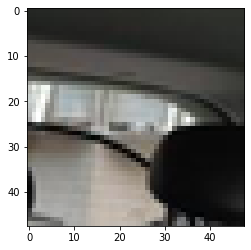

tb: 0; pb: 0.0
body: [ 0.  0. -0.  0.]


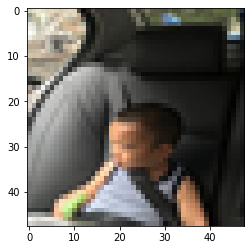

tb: 1; pb: 0.9
body: [ 4. 21. 44. 48.]


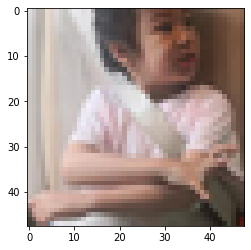

tb: 1; pb: 0.9
body: [ 4.  0. 47. 46.]


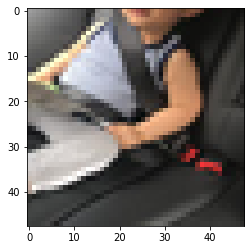

tb: 1; pb: 0.9
body: [ 1. -0. 42. 34.]


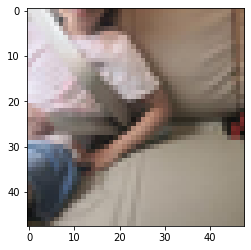

tb: 1; pb: 0.8
body: [ 0.  0. 32. 41.]


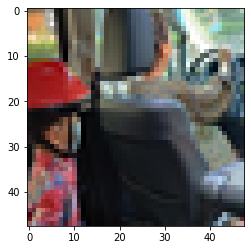

tb: 1; pb: 0.7
body: [-1. 11. 21. 52.]


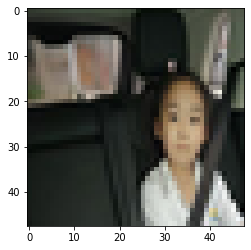

tb: 1; pb: 0.7
body: [20. 16. 44. 42.]


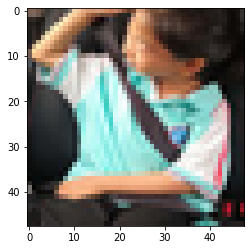

tb: 1; pb: 0.9
body: [ 1. -0. 46. 48.]


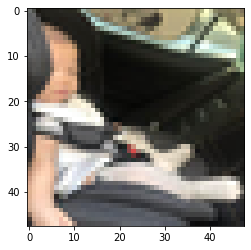

tb: 1; pb: 0.8
body: [ 0.  2. 27. 45.]


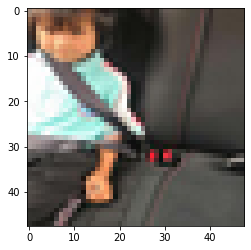

tb: 1; pb: 0.7
body: [ 1.  0. 22. 45.]


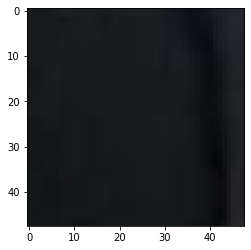

tb: 0; pb: 0.0
body: [0. 0. 0. 0.]


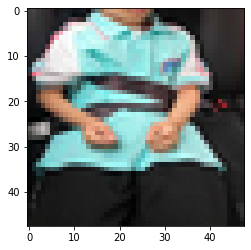

tb: 1; pb: 0.9
body: [ 1.  0. 38. 37.]


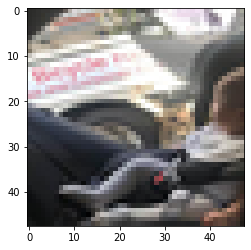

tb: 1; pb: 0.8
body: [27.  9. 48. 49.]


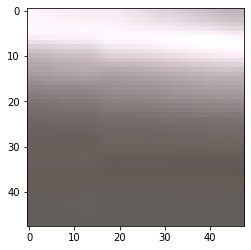

tb: 0; pb: 0.0
body: [ 0.  0. -0.  0.]


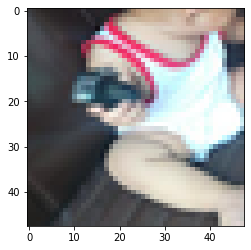

tb: 1; pb: 0.8
body: [ 7. -1. 47. 33.]


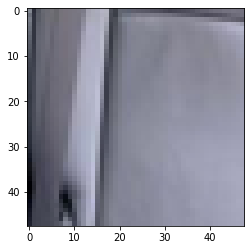

tb: 0; pb: 0.0
body: [ 0. -0.  0. -0.]


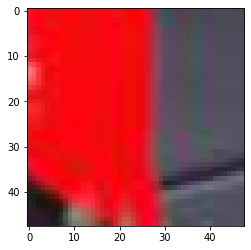

tb: 0; pb: 0.0
body: [1. 0. 0. 0.]


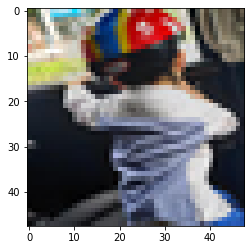

tb: 1; pb: 0.9
body: [ 9.  0. 50. 47.]


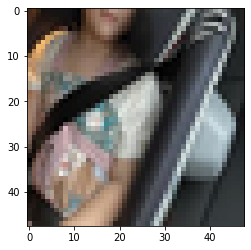

tb: 1; pb: 0.8
body: [-0. -0. 34. 47.]


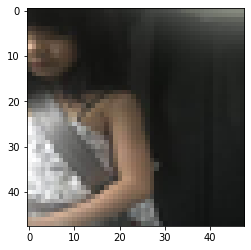

tb: 1; pb: 0.8
body: [ 0. -0. 31. 48.]


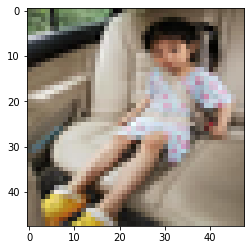

tb: 1; pb: 0.8
body: [17.  2. 47. 28.]


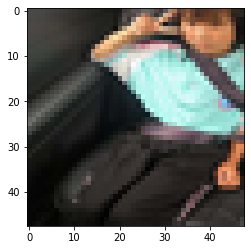

tb: 1; pb: 0.8
body: [12.  0. 49. 42.]


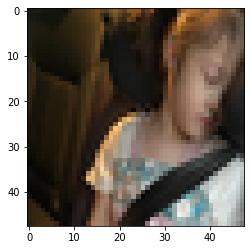

tb: 1; pb: 0.9
body: [ 7.  1. 48. 48.]


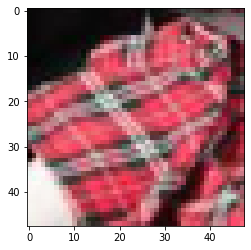

tb: 0; pb: 0.0
body: [ 5. -1.  7. -2.]


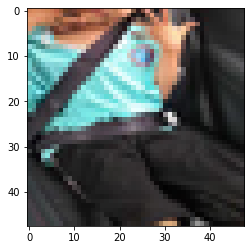

tb: 1; pb: 0.8
body: [-1. -0. 40. 26.]


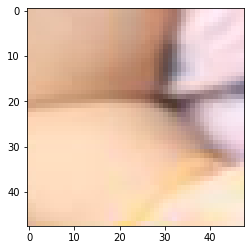

tb: 0; pb: 0.0
body: [ 0. -0. -0.  0.]


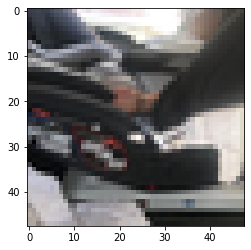

tb: 1; pb: 0.8
body: [14. -1. 48. 32.]


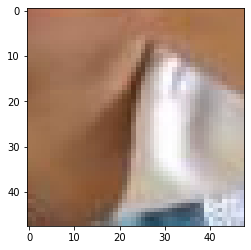

tb: 0; pb: 0.0
body: [ 0.  0. -0.  0.]


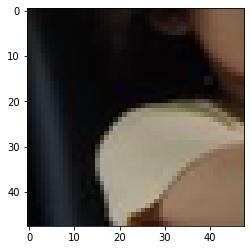

tb: 0; pb: 0.0
body: [-0.  0. -0. -0.]


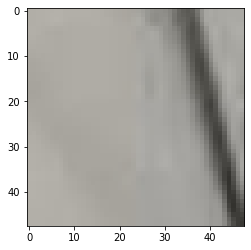

tb: 0; pb: 0.0
body: [-0. -0.  0.  0.]


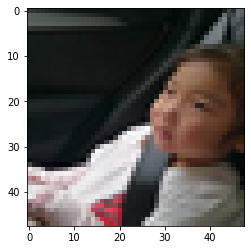

tb: 1; pb: 0.9
body: [-1.  9. 49. 48.]


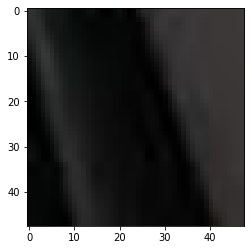

tb: 0; pb: 0.0
body: [ 0. -0. -0.  0.]


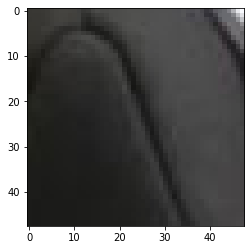

tb: 0; pb: 0.0
body: [ 0. -0.  0. -0.]


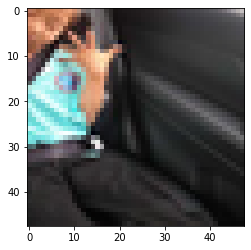

tb: 1; pb: 0.7
body: [-1. -0. 24. 33.]


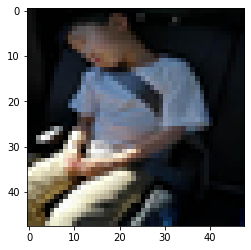

tb: 1; pb: 0.9
body: [ 2.  0. 43. 41.]


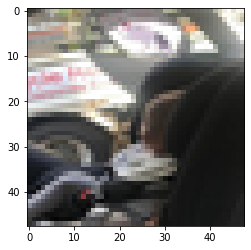

tb: 1; pb: 0.8
body: [10. 16. 39. 49.]


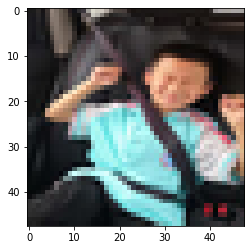

tb: 1; pb: 0.9
body: [ 2.  9. 47. 49.]


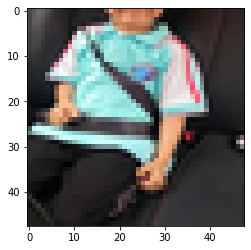

tb: 1; pb: 0.9
body: [ 3. -0. 37. 41.]


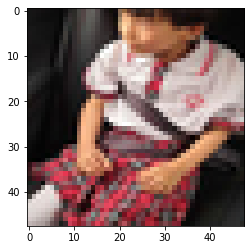

tb: 1; pb: 1.0
body: [ 7. -0. 49. 44.]


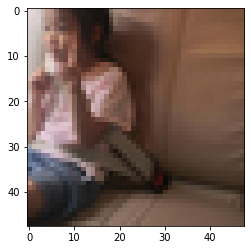

tb: 1; pb: 0.8
body: [-0.  0. 27. 40.]


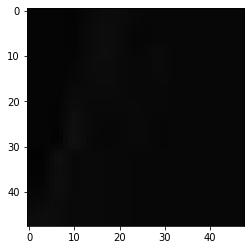

tb: 0; pb: 0.0
body: [0. 0. 0. 0.]


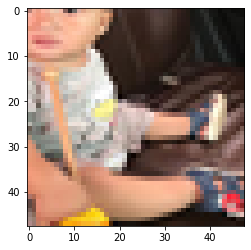

tb: 1; pb: 0.7
body: [-1. -0. 25. 46.]


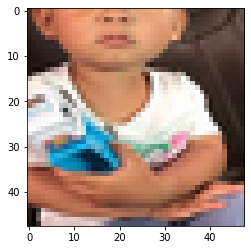

tb: 1; pb: 0.9
body: [-1. -0. 47. 49.]


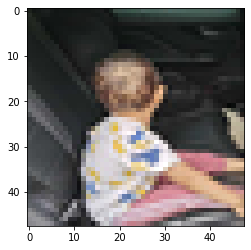

tb: 1; pb: 0.9
body: [ 8.  6. 47. 50.]


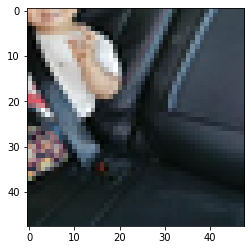

tb: 1; pb: 0.7
body: [-0.  2. 24. 38.]


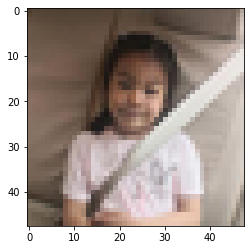

tb: 1; pb: 0.9
body: [ 4.  3. 41. 49.]


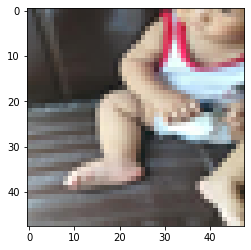

tb: 1; pb: 0.8
body: [17. -0. 50. 34.]


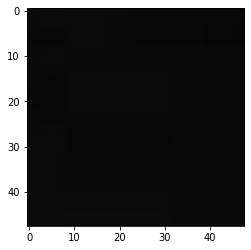

tb: 0; pb: 0.0
body: [0. 0. 0. 0.]


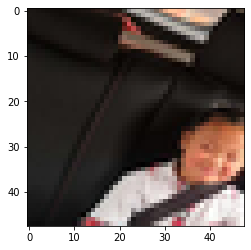

tb: 1; pb: 0.7
body: [11. 23. 48. 48.]


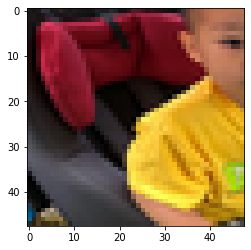

tb: 1; pb: 0.8
body: [17. -1. 49. 49.]


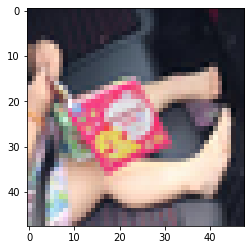

tb: 1; pb: 0.8
body: [-0. -1. 24. 40.]


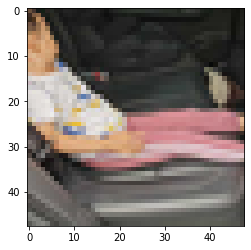

tb: 1; pb: 0.8
body: [-0. -0. 26. 38.]


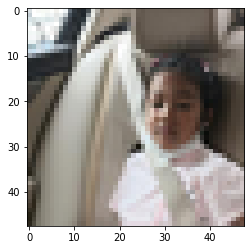

tb: 1; pb: 0.9
body: [12.  8. 50. 49.]


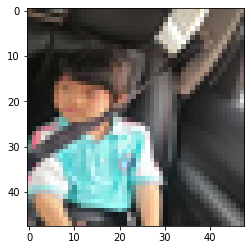

tb: 1; pb: 0.9
body: [ 0.  8. 34. 49.]


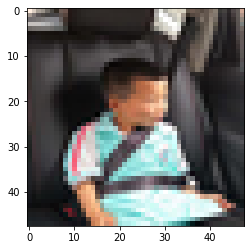

tb: 1; pb: 0.9
body: [ 8. 11. 48. 48.]


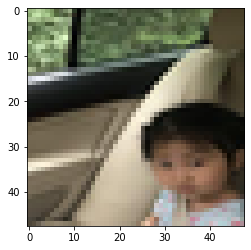

tb: 1; pb: 0.8
body: [14. 13. 46. 44.]


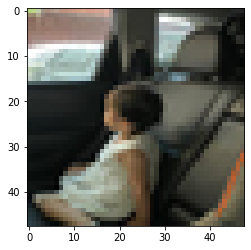

tb: 1; pb: 0.7
body: [ 4. 15. 31. 47.]


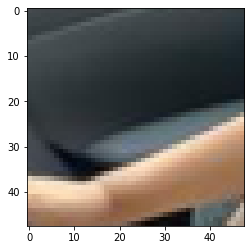

tb: 0; pb: 0.0
body: [ 0.  0.  0. -0.]


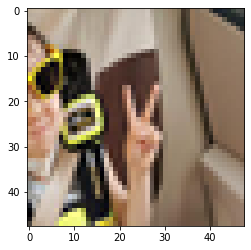

tb: 1; pb: 0.8
body: [ 0.  6. 28. 48.]


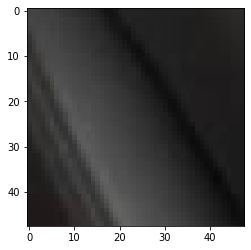

tb: 0; pb: 0.0
body: [ 0. -0.  0.  0.]


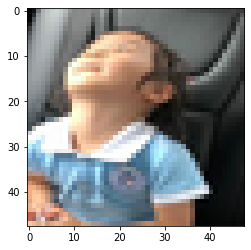

tb: 1; pb: 0.9
body: [ 1.  1. 37. 48.]


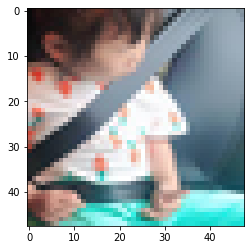

tb: 1; pb: 0.9
body: [-0. -0. 37. 49.]


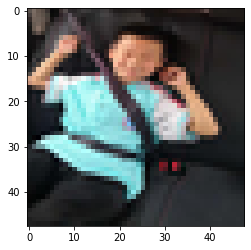

tb: 1; pb: 0.9
body: [-0.  1. 44. 41.]


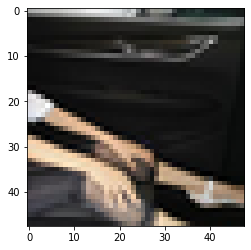

tb: 1; pb: 0.8
body: [ 0.  3. 28. 48.]


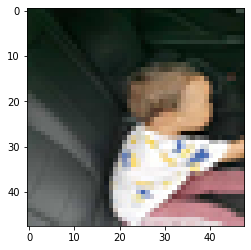

tb: 1; pb: 0.9
body: [15.  9. 48. 47.]


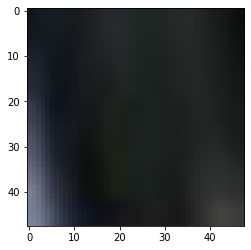

tb: 0; pb: 0.0
body: [ 0. -0. -0. -0.]


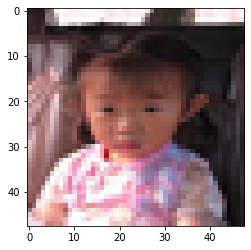

tb: 1; pb: 0.9
body: [ 0.  4. 48. 50.]


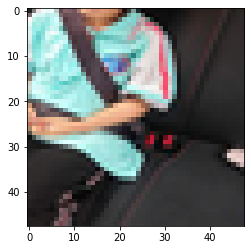

tb: 1; pb: 0.8
body: [-1. -1. 33. 32.]


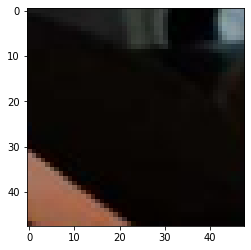

tb: 0; pb: 0.0
body: [ 0. -0. -0. -0.]


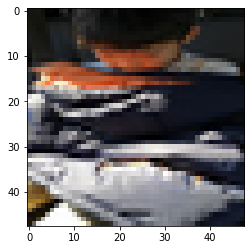

tb: 1; pb: 0.9
body: [ 4.  0. 48. 44.]


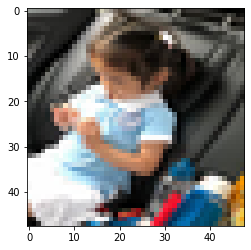

tb: 1; pb: 0.9
body: [ 0. -0. 34. 42.]


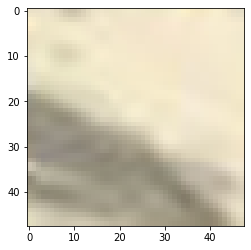

tb: 0; pb: 0.0
body: [-0.  0. -0.  0.]


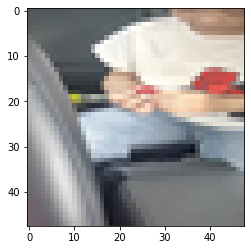

tb: 1; pb: 0.2
body: [10.  0. 38. 18.]


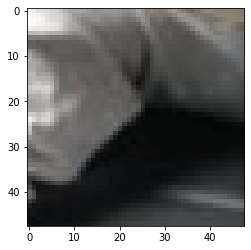

tb: 0; pb: 0.0
body: [0. 0. 0. 0.]


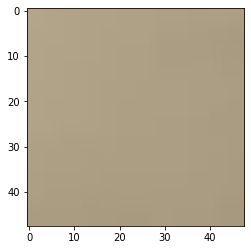

tb: 0; pb: 0.0
body: [ 0. -0. -0.  0.]


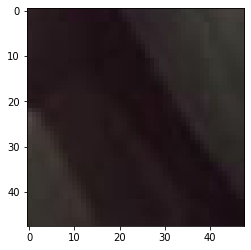

tb: 0; pb: 0.0
body: [0. 0. 0. 0.]


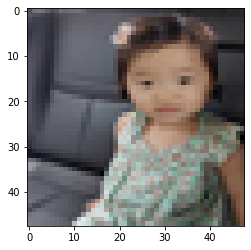

tb: 1; pb: 0.9
body: [ 9.  1. 50. 49.]


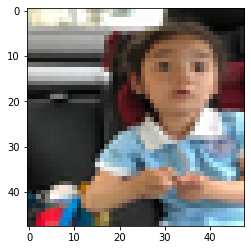

tb: 1; pb: 0.9
body: [ 8.  1. 48. 48.]


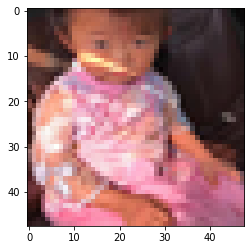

tb: 1; pb: 0.9
body: [-0.  0. 46. 49.]


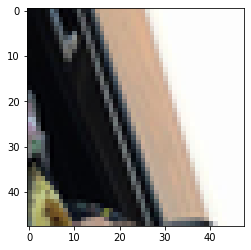

tb: 1; pb: 0.8
body: [-1.  9. 37. 46.]


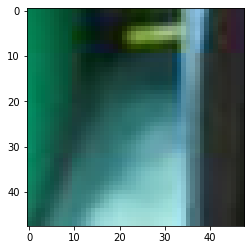

tb: 0; pb: 0.0
body: [-0. -0. -0. -0.]


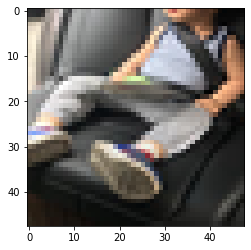

tb: 1; pb: 0.8
body: [15. -0. 48. 25.]


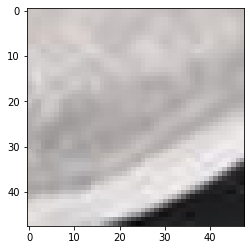

tb: 0; pb: 0.0
body: [-0. -0. -0. -0.]


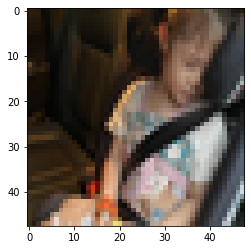

tb: 1; pb: 0.9
body: [11.  1. 45. 48.]


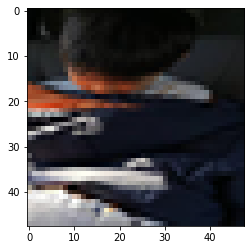

tb: 1; pb: 0.9
body: [-0.  1. 44. 48.]


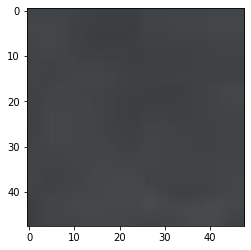

tb: 0; pb: 0.0
body: [ 0. -0. -0.  0.]


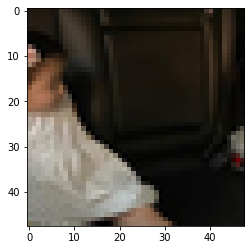

tb: 1; pb: 0.7
body: [ 1.  1. 18. 49.]


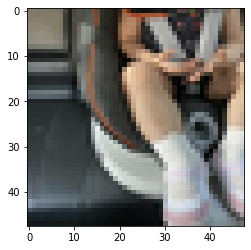

tb: 1; pb: 0.7
body: [16.  0. 49. 24.]


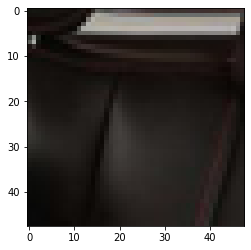

tb: 0; pb: 0.0
body: [ 0. -0.  0. -0.]


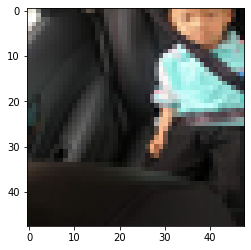

tb: 1; pb: 0.8
body: [21. -1. 50. 41.]


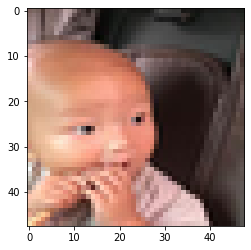

tb: 1; pb: 0.8
body: [ 0.  6. 42. 50.]


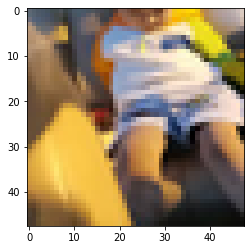

tb: 1; pb: 0.8
body: [ 2. -1. 44. 38.]


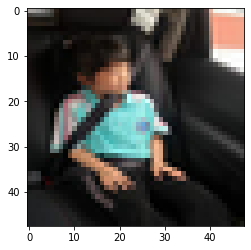

tb: 1; pb: 0.9
body: [ 5.  5. 35. 43.]


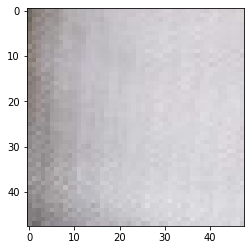

tb: 0; pb: 0.0
body: [-0. -0. -0. -0.]


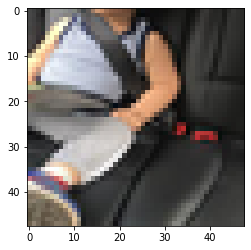

tb: 1; pb: 0.8
body: [-0.  0. 37. 35.]


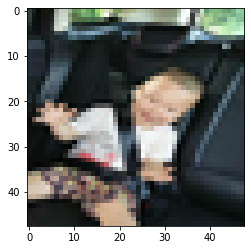

tb: 1; pb: 0.9
body: [ 1. 12. 40. 39.]


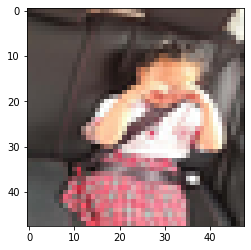

tb: 1; pb: 0.9
body: [11.  5. 45. 42.]


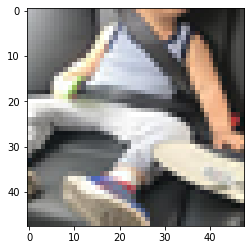

tb: 1; pb: 0.9
body: [ 4. -0. 47. 34.]


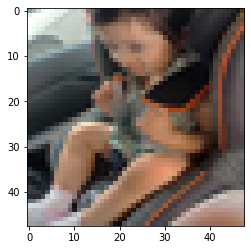

tb: 1; pb: 0.9
body: [ 6.  1. 42. 39.]


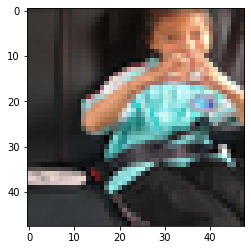

tb: 1; pb: 0.9
body: [10. -0. 50. 33.]


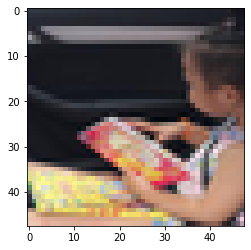

tb: 1; pb: 0.8
body: [18.  5. 47. 48.]


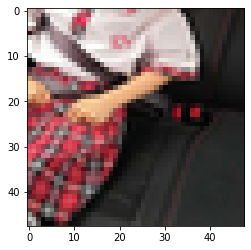

tb: 1; pb: 0.8
body: [ 1. -0. 39. 27.]


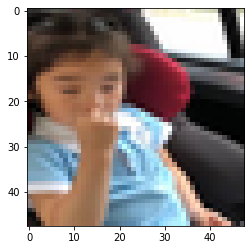

tb: 1; pb: 0.9
body: [ 0.  3. 45. 50.]


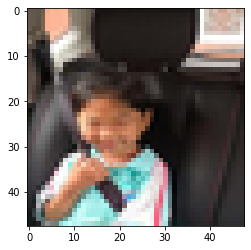

tb: 1; pb: 0.8
body: [ 1. 13. 32. 47.]


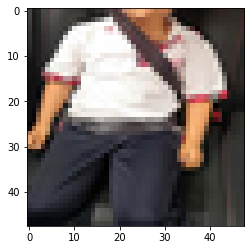

tb: 1; pb: 0.9
body: [-1.  0. 44. 38.]


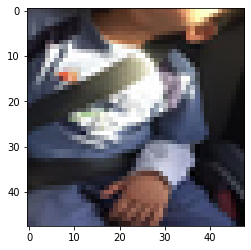

tb: 1; pb: 0.9
body: [-1. -0. 47. 47.]


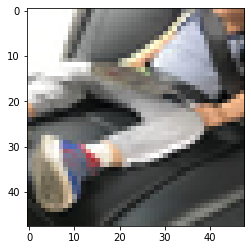

tb: 1; pb: 0.8
body: [17.  0. 48. 29.]


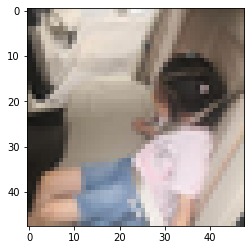

tb: 1; pb: 0.8
body: [21.  8. 42. 48.]


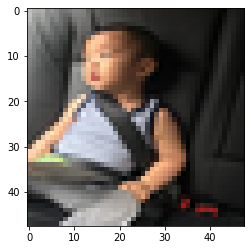

tb: 1; pb: 0.9
body: [-0.  3. 37. 45.]


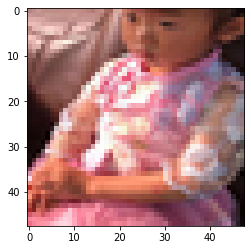

tb: 1; pb: 0.9
body: [-1. -0. 48. 48.]


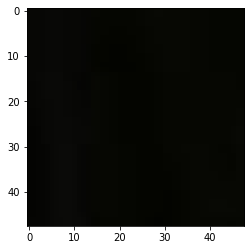

tb: 0; pb: 0.0
body: [ 0.  0. -0.  0.]


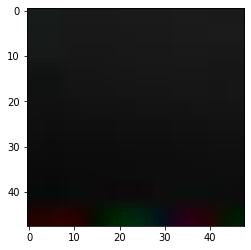

tb: 0; pb: 0.0
body: [ 0. -0. -0.  0.]


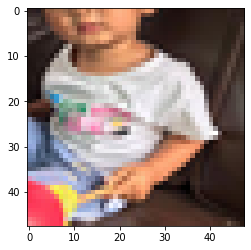

tb: 1; pb: 0.9
body: [ 1.  0. 40. 46.]


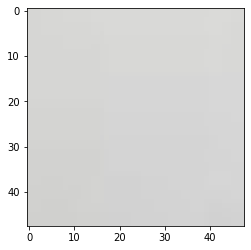

tb: 0; pb: 0.0
body: [ 0. -0. -0. -0.]


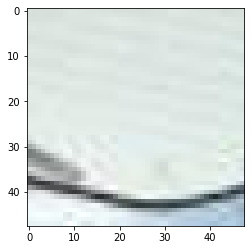

tb: 0; pb: 0.0
body: [ 0. -0. -0. -0.]


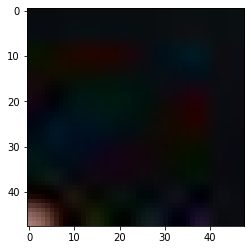

tb: 0; pb: 0.0
body: [-0.  0. -0.  0.]


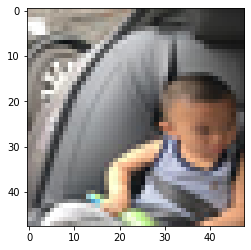

tb: 1; pb: 0.8
body: [17. 15. 50. 48.]


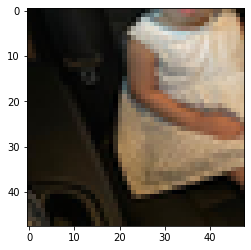

tb: 1; pb: 0.7
body: [17. -1. 48. 31.]


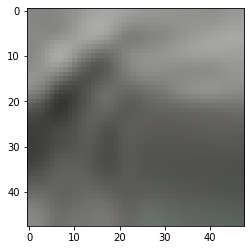

tb: 0; pb: 0.0
body: [ 0. -0. -0.  0.]


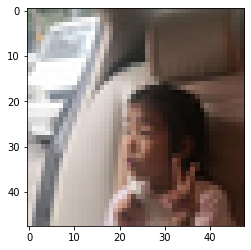

tb: 1; pb: 0.8
body: [ 9. 13. 45. 48.]


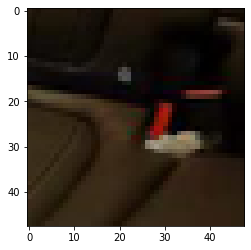

tb: 0; pb: 0.0
body: [0. 1. 0. 0.]


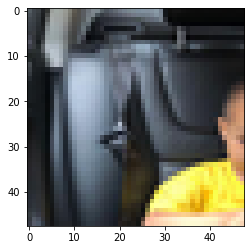

tb: 1; pb: 0.7
body: [25. 10. 46. 48.]


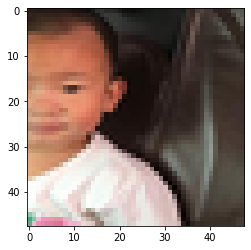

tb: 1; pb: 0.8
body: [ 0.  0. 34. 48.]


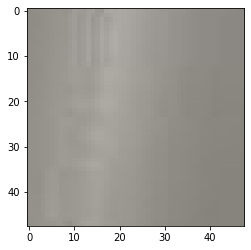

tb: 0; pb: 0.0
body: [ 0. -0. -0. -0.]


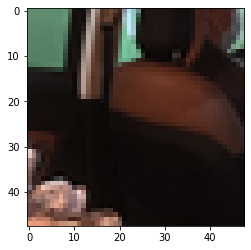

tb: 1; pb: 0.5
body: [ 1. 21. 16. 43.]


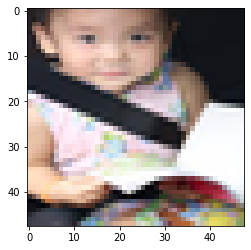

tb: 1; pb: 0.9
body: [ 0.  0. 48. 45.]


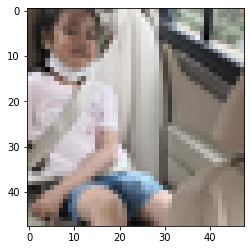

tb: 1; pb: 0.8
body: [-0.  0. 26. 50.]


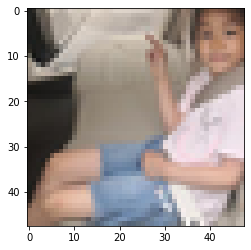

tb: 1; pb: 0.8
body: [27. -0. 47. 43.]


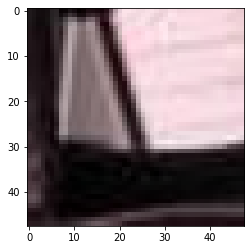

tb: 0; pb: 0.0
body: [ 0. -0.  0. -0.]


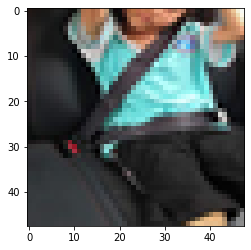

tb: 1; pb: 0.8
body: [ 8. -1. 46. 30.]


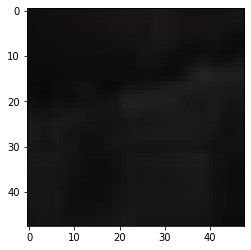

tb: 0; pb: 0.0
body: [ 0. -0.  0.  0.]


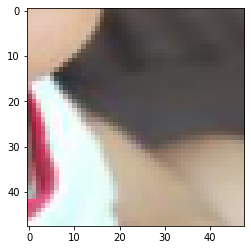

tb: 0; pb: 0.0
body: [-0. -0.  0.  0.]


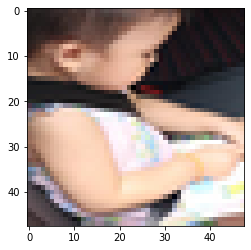

tb: 1; pb: 0.9
body: [ 0.  1. 48. 43.]


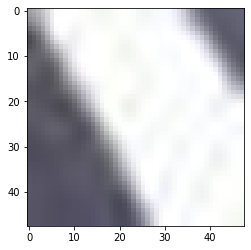

tb: 0; pb: 0.0
body: [ 0. -0. -0. -0.]


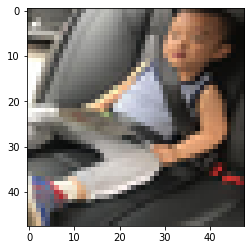

tb: 1; pb: 0.9
body: [11. -0. 47. 37.]


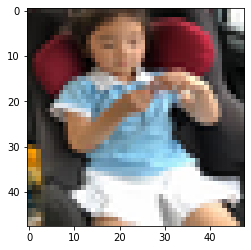

tb: 1; pb: 0.9
body: [ 3. -0. 46. 40.]


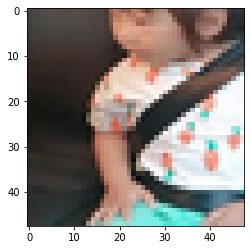

tb: 1; pb: 0.9
body: [10.  1. 48. 48.]


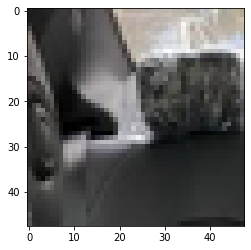

tb: 0; pb: 0.1
body: [ 1.  2. 11. 12.]


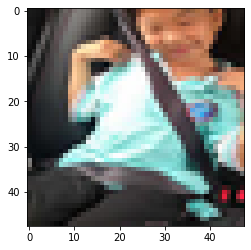

tb: 1; pb: 0.9
body: [ 7. -0. 50. 47.]


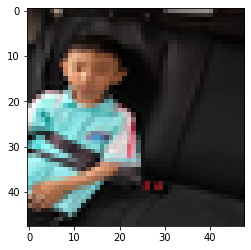

tb: 1; pb: 0.8
body: [ 0.  5. 27. 44.]


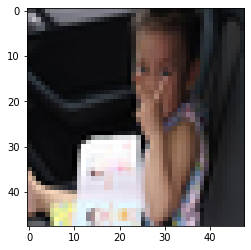

tb: 1; pb: 0.9
body: [15.  0. 38. 51.]


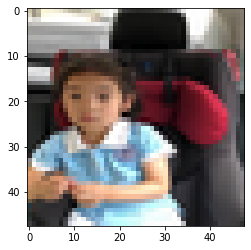

tb: 1; pb: 0.9
body: [-0.  8. 35. 50.]


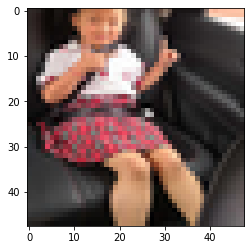

tb: 1; pb: 0.9
body: [ 1. -0. 35. 34.]


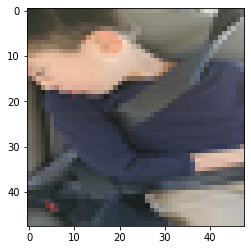

tb: 1; pb: 0.9
body: [-0. -1. 47. 48.]


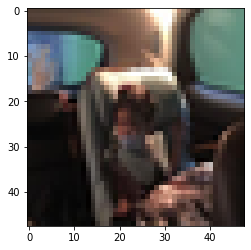

tb: 1; pb: 0.9
body: [11. 15. 39. 47.]


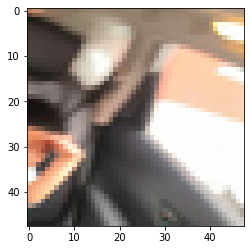

tb: 1; pb: 0.7
body: [-0.  9. 28. 42.]


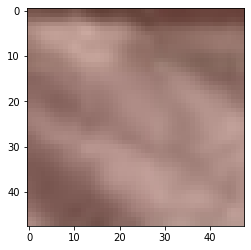

tb: 0; pb: 0.0
body: [ 0. -0. -0.  0.]


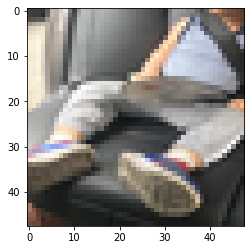

tb: 1; pb: 0.7
body: [23. -0. 49. 26.]


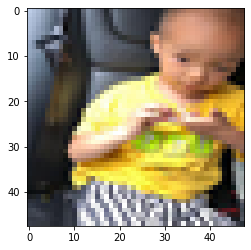

tb: 1; pb: 0.9
body: [11. -0. 49. 36.]


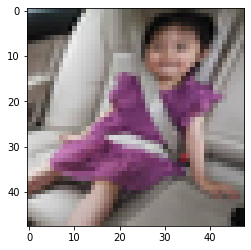

tb: 1; pb: 0.9
body: [ 7. -0. 47. 45.]


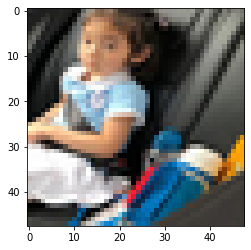

tb: 1; pb: 0.9
body: [-0. -0. 29. 39.]


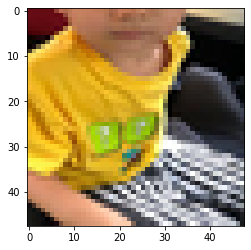

tb: 1; pb: 0.8
body: [ 1. -0. 41. 49.]


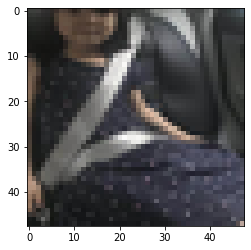

tb: 1; pb: 0.9
body: [-0. -0. 39. 45.]


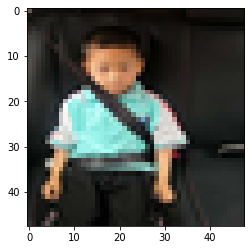

tb: 1; pb: 0.9
body: [ 2.  2. 31. 45.]


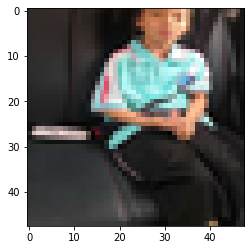

tb: 1; pb: 0.8
body: [14.  0. 42. 31.]


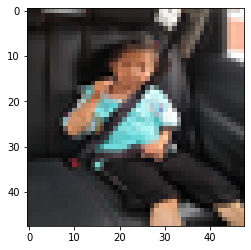

tb: 1; pb: 0.8
body: [ 7.  4. 33. 35.]


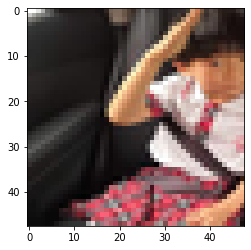

tb: 1; pb: 0.9
body: [14.  1. 49. 47.]


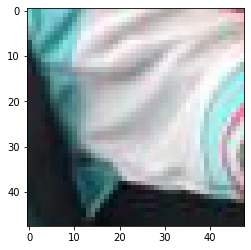

tb: 0; pb: 0.0
body: [-0. -0. -0.  0.]


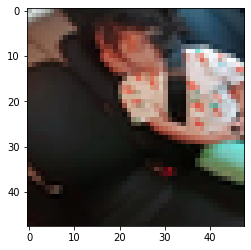

tb: 1; pb: 0.8
body: [14.  0. 49. 31.]


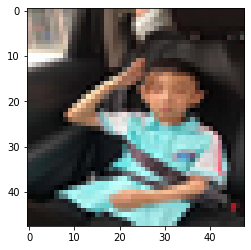

tb: 1; pb: 0.9
body: [ 7. 11. 45. 48.]


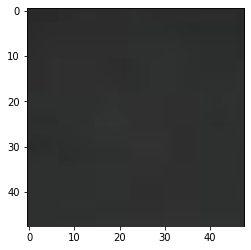

tb: 0; pb: 0.0
body: [ 0. -0. -0.  0.]


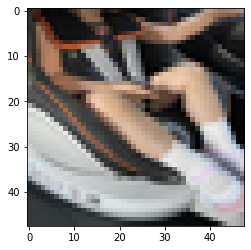

tb: 1; pb: 0.8
body: [ 2. -0. 45. 24.]


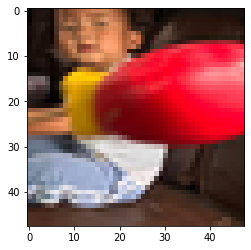

tb: 1; pb: 0.8
body: [ 1.  1. 33. 46.]


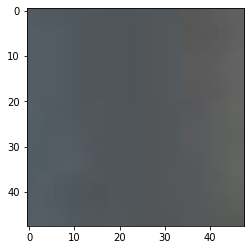

tb: 0; pb: 0.0
body: [ 0. -0. -0.  0.]


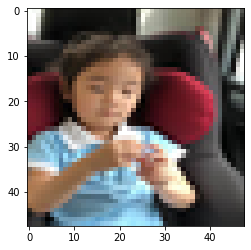

tb: 1; pb: 0.9
body: [-0.  6. 42. 48.]


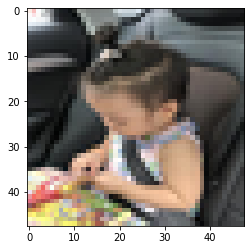

tb: 1; pb: 0.9
body: [ 5.  5. 42. 49.]


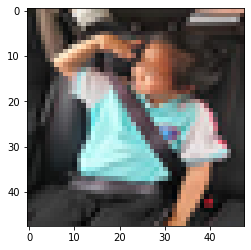

tb: 1; pb: 0.9
body: [ 2.  1. 46. 49.]


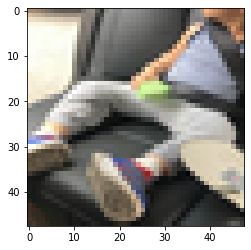

tb: 1; pb: 0.7
body: [22. -0. 48. 34.]


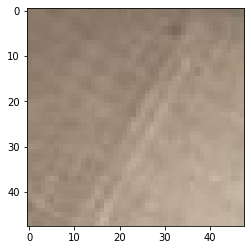

tb: 0; pb: 0.0
body: [ 0. -0. -0. -0.]


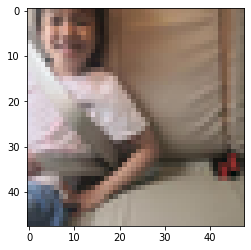

tb: 1; pb: 0.8
body: [-0. -0. 31. 47.]


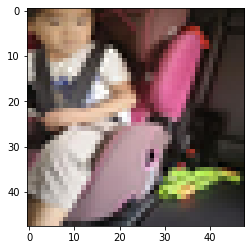

tb: 1; pb: 0.8
body: [ 0.  0. 26. 35.]


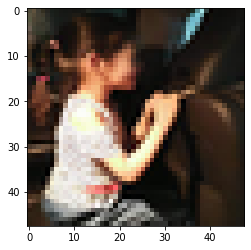

tb: 1; pb: 0.9
body: [ 2.  2. 37. 49.]


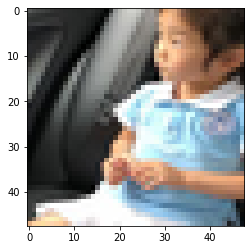

tb: 1; pb: 0.9
body: [11. -0. 48. 48.]


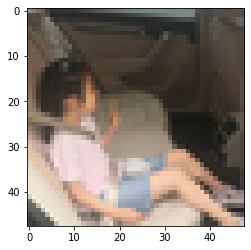

tb: 1; pb: 0.9
body: [ 2.  8. 33. 48.]


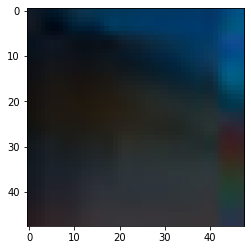

tb: 0; pb: 0.0
body: [-0. -0. -0. -0.]


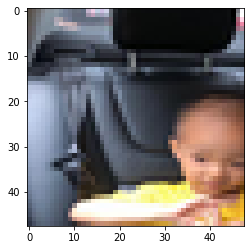

tb: 1; pb: 0.8
body: [13. 20. 50. 49.]


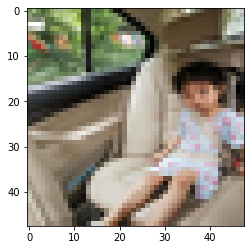

tb: 1; pb: 0.7
body: [24. 11. 46. 37.]


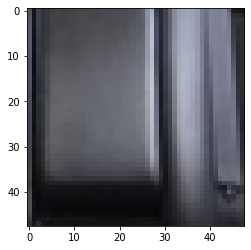

tb: 0; pb: 0.0
body: [ 2. -0. -0.  0.]


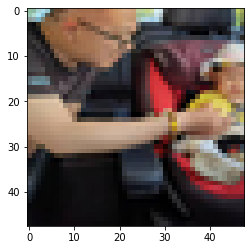

tb: 1; pb: 0.7
body: [21.  2. 49. 36.]


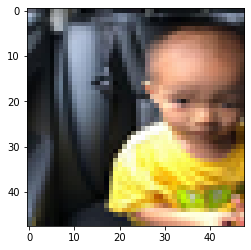

tb: 1; pb: 0.8
body: [20.  4. 49. 49.]


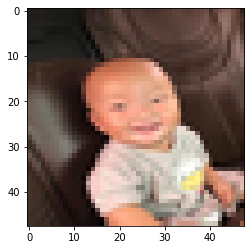

tb: 1; pb: 0.9
body: [12. 11. 48. 49.]


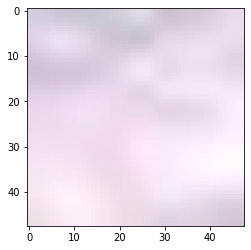

tb: 0; pb: 0.0
body: [ 0. -0. -0.  0.]


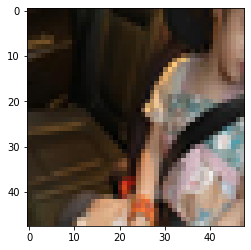

tb: 1; pb: 0.9
body: [19. -0. 49. 49.]


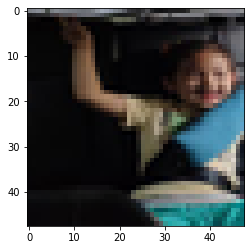

tb: 1; pb: 0.8
body: [13.  3. 49. 47.]


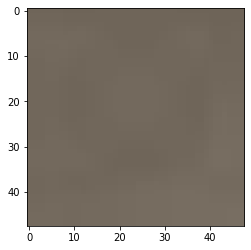

tb: 0; pb: 0.0
body: [ 0. -0. -0.  0.]


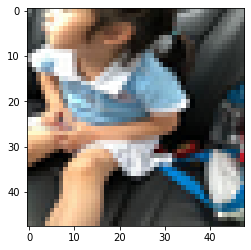

tb: 1; pb: 0.8
body: [-1. -1. 35. 38.]


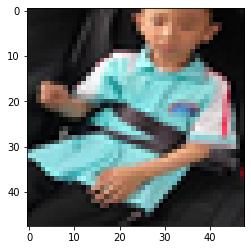

tb: 1; pb: 1.0
body: [ 1.  0. 47. 46.]


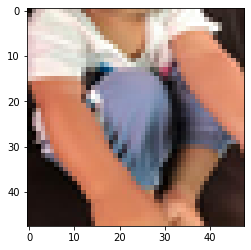

tb: 1; pb: 0.9
body: [ 1. -0. 51. 51.]


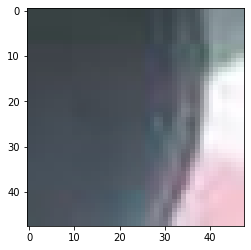

tb: 0; pb: 0.0
body: [ 0. -0. -0.  0.]


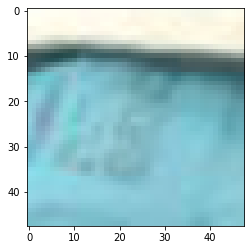

tb: 0; pb: 0.0
body: [ 0. -0.  0.  0.]


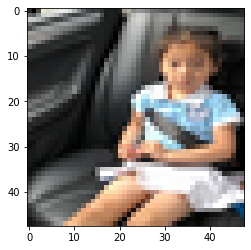

tb: 1; pb: 0.9
body: [20.  2. 48. 41.]


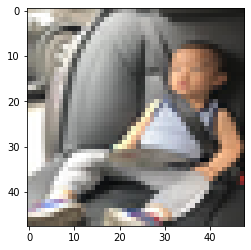

tb: 1; pb: 0.9
body: [18.  6. 47. 40.]


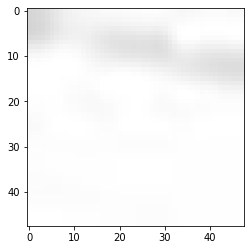

tb: 0; pb: 0.0
body: [ 0. -0. -0. -0.]


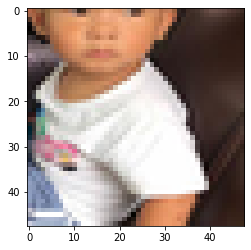

tb: 1; pb: 0.9
body: [-2. -0. 39. 48.]


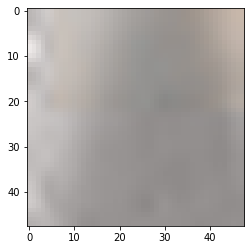

tb: 0; pb: 0.0
body: [ 0.  0. -0.  0.]


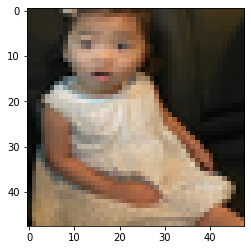

tb: 1; pb: 0.9
body: [ 1.  0. 43. 47.]


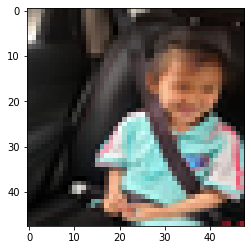

tb: 1; pb: 0.9
body: [15.  6. 47. 48.]


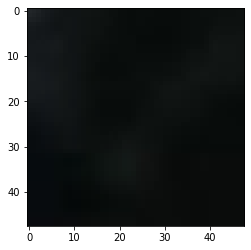

tb: 0; pb: 0.0
body: [0. 0. 0. 0.]


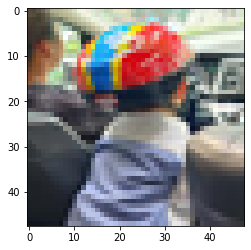

tb: 1; pb: 0.9
body: [ 8.  4. 38. 49.]


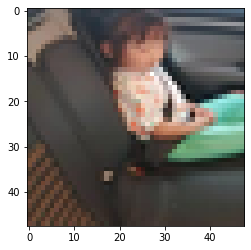

tb: 1; pb: 0.9
body: [14.  0. 46. 37.]


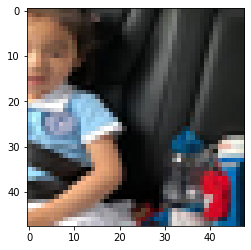

tb: 1; pb: 0.8
body: [ 1.  0. 24. 47.]


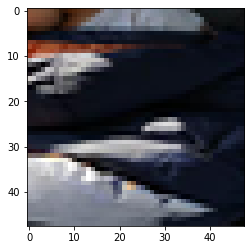

tb: 1; pb: 0.9
body: [ 2. -1. 44. 41.]


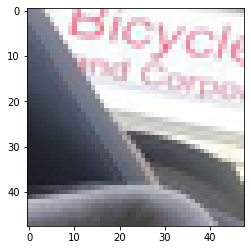

tb: 0; pb: 0.1
body: [ 2. -1. 27. 15.]


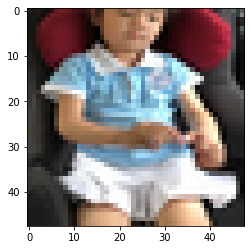

tb: 1; pb: 0.9
body: [ 2. -0. 44. 41.]


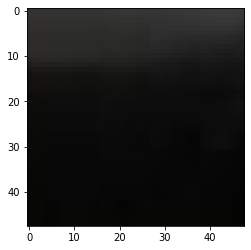

tb: 0; pb: 0.0
body: [0. 0. 0. 0.]


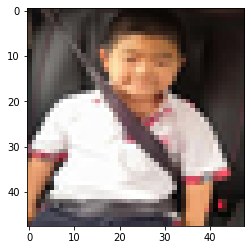

tb: 1; pb: 0.9
body: [ 1.  0. 44. 47.]


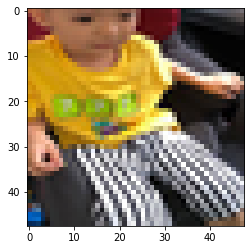

tb: 1; pb: 0.9
body: [ 0. -0. 47. 42.]


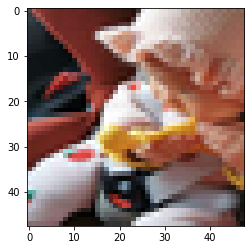

tb: 1; pb: 0.9
body: [12.  1. 50. 45.]


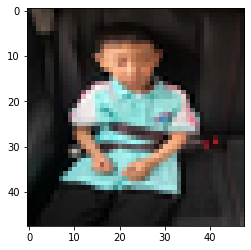

tb: 1; pb: 0.9
body: [ 9.  4. 36. 42.]


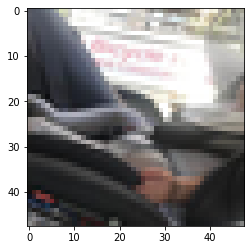

tb: 1; pb: 0.8
body: [18.  6. 47. 43.]


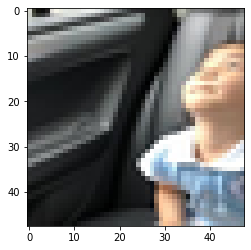

tb: 1; pb: 0.8
body: [27.  1. 49. 49.]


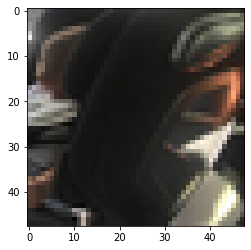

tb: 1; pb: 0.7
body: [ 3.  2. 22. 49.]


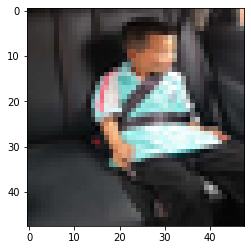

tb: 1; pb: 0.9
body: [15.  1. 45. 37.]


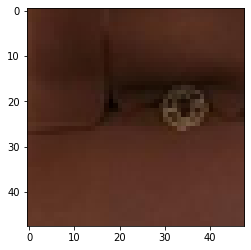

tb: 0; pb: 0.0
body: [ 0. -0.  0.  0.]


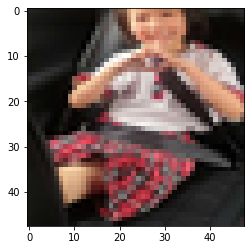

tb: 1; pb: 0.9
body: [ 9.  0. 48. 34.]


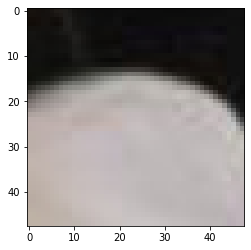

tb: 0; pb: 0.0
body: [ 0. -0.  0.  0.]


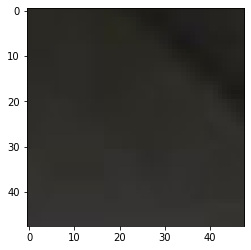

tb: 0; pb: 0.0
body: [ 0. -0. -0.  0.]


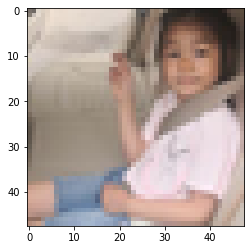

tb: 1; pb: 0.9
body: [13.  1. 44. 48.]


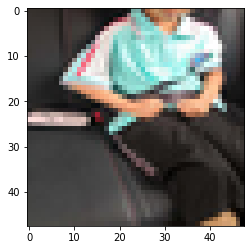

tb: 1; pb: 0.8
body: [ 8.  0. 43. 26.]


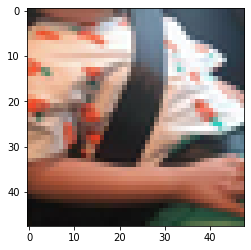

tb: 1; pb: 0.8
body: [-0.  0. 46. 41.]


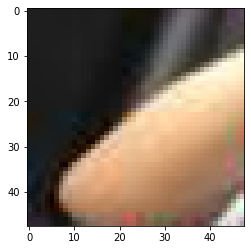

tb: 0; pb: 0.0
body: [-0. -0.  0.  1.]


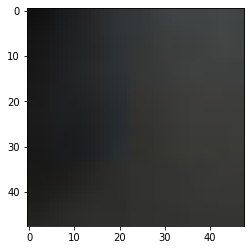

tb: 0; pb: 0.0
body: [ 0. -0. -0.  0.]


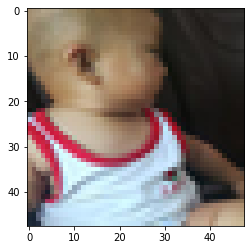

tb: 1; pb: 0.9
body: [ 0. -0. 49. 50.]


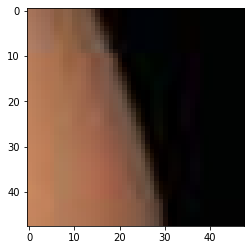

tb: 0; pb: 0.0
body: [ 0.  0. -0.  0.]


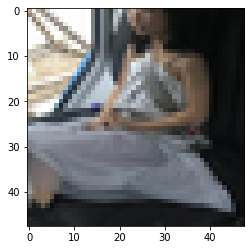

tb: 1; pb: 0.8
body: [10. -0. 39. 33.]


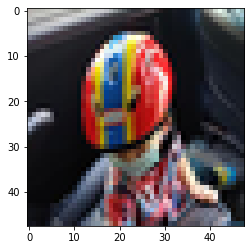

tb: 1; pb: 0.8
body: [12.  5. 44. 50.]


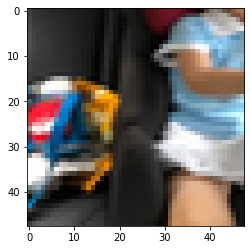

tb: 1; pb: 0.7
body: [25. -1. 49. 41.]


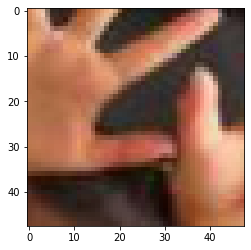

tb: 0; pb: 0.0
body: [-0. -0. -0.  0.]


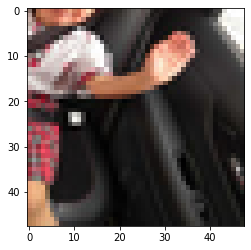

tb: 1; pb: 0.8
body: [-0. -0. 36. 29.]


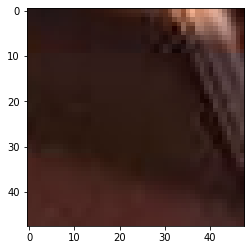

tb: 0; pb: 0.0
body: [ 0. -0. -0. -0.]


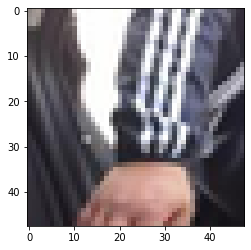

tb: 0; pb: 0.0
body: [5. 3. 1. 4.]


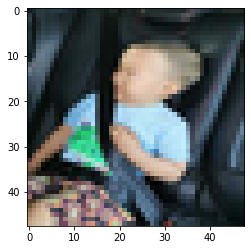

tb: 1; pb: 0.9
body: [-1.  3. 42. 47.]


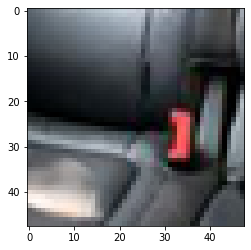

tb: 0; pb: 0.0
body: [ 0.  0. -0. -0.]


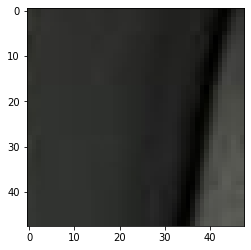

tb: 0; pb: 0.0
body: [ 0. -0. -0.  0.]


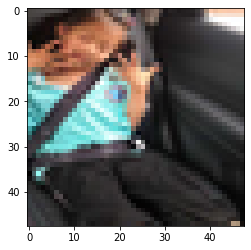

tb: 1; pb: 0.8
body: [-1.  0. 31. 29.]


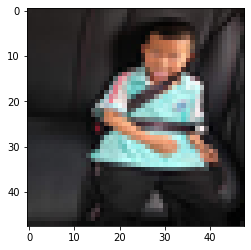

tb: 1; pb: 0.9
body: [12.  1. 44. 38.]


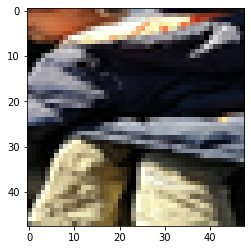

tb: 1; pb: 0.9
body: [ 3. -0. 51. 34.]


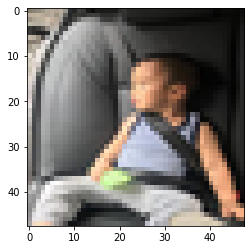

tb: 1; pb: 0.9
body: [11.  9. 50. 49.]


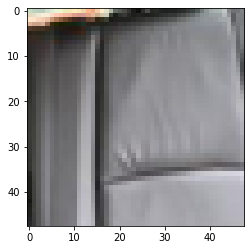

tb: 0; pb: 0.0
body: [-0. -0. -0. -0.]


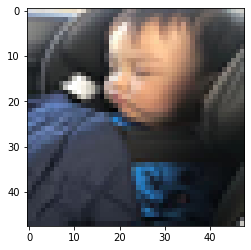

tb: 1; pb: 0.9
body: [ 1. -0. 48. 45.]


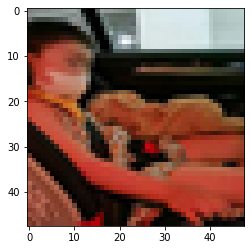

tb: 1; pb: 0.9
body: [ 0.  2. 44. 46.]


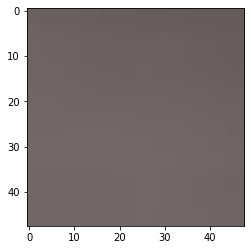

tb: 0; pb: 0.0
body: [ 0. -0. -0.  0.]


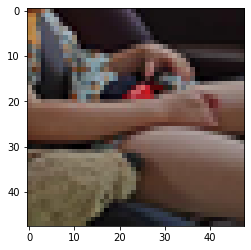

tb: 1; pb: 0.8
body: [-1. -0. 43. 33.]


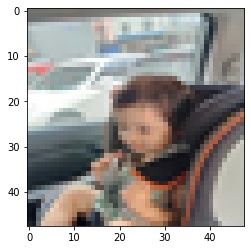

tb: 1; pb: 0.8
body: [ 8. 15. 36. 49.]


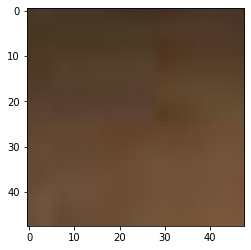

tb: 0; pb: 0.0
body: [ 0.  0. -0. -0.]


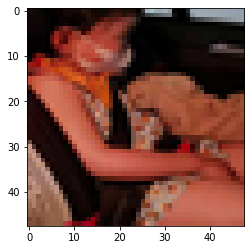

tb: 1; pb: 0.9
body: [ 1.  0. 46. 43.]


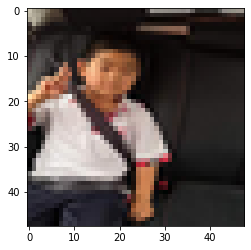

tb: 1; pb: 0.9
body: [ 0.  5. 32. 48.]


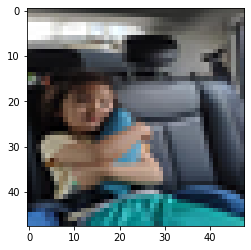

tb: 1; pb: 0.9
body: [ 1. 12. 35. 48.]


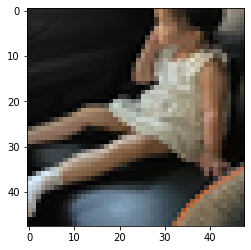

tb: 1; pb: 0.8
body: [19. -0. 49. 41.]


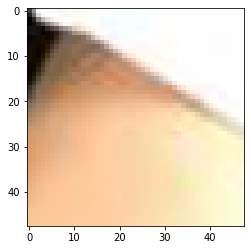

tb: 0; pb: 0.0
body: [ 0. -0. -0. -0.]


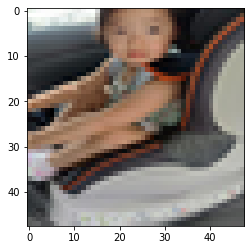

tb: 1; pb: 0.9
body: [-1. -1. 38. 38.]


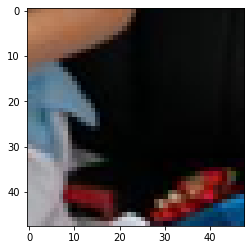

tb: 0; pb: 0.0
body: [-0. -0. -0. -0.]


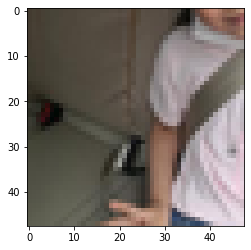

tb: 1; pb: 0.8
body: [22. -1. 48. 50.]


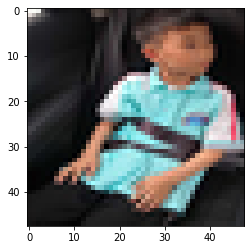

tb: 1; pb: 0.9
body: [ 5. -0. 47. 47.]


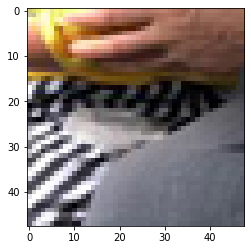

tb: 0; pb: 0.0
body: [-0. -1. -1. -0.]


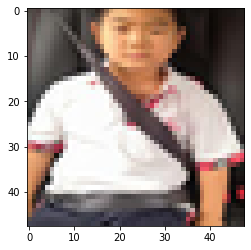

tb: 1; pb: 0.9
body: [ 1. -1. 48. 50.]


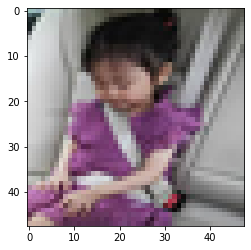

tb: 1; pb: 0.9
body: [-1.  3. 38. 46.]


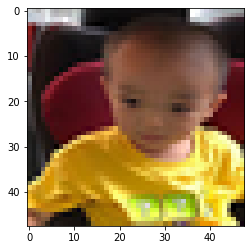

tb: 1; pb: 0.9
body: [ 3.  2. 49. 48.]


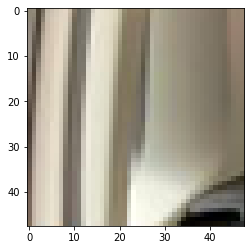

tb: 0; pb: 0.0
body: [-1. -0. -0.  0.]


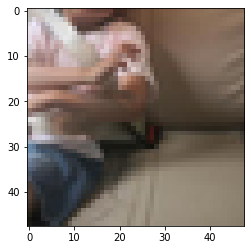

tb: 1; pb: 0.8
body: [ 0. -0. 35. 33.]


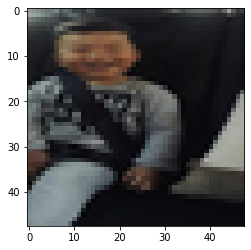

tb: 1; pb: 0.8
body: [ 1.  0. 33. 45.]


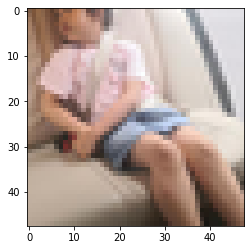

tb: 1; pb: 0.8
body: [-0. -0. 28. 34.]


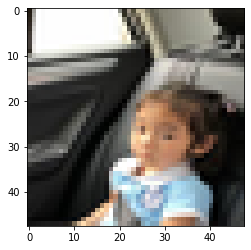

tb: 1; pb: 0.9
body: [ 8. 15. 46. 48.]


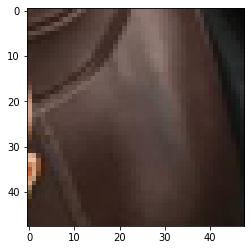

tb: 0; pb: 0.0
body: [-0.  0.  1.  3.]


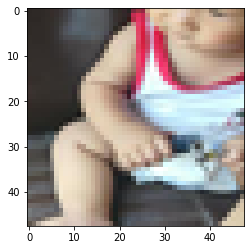

tb: 1; pb: 0.9
body: [11. -0. 49. 42.]


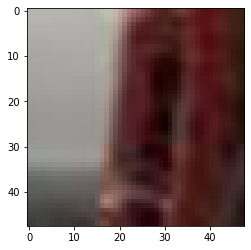

tb: 0; pb: 0.0
body: [-0.  0. -0. -0.]


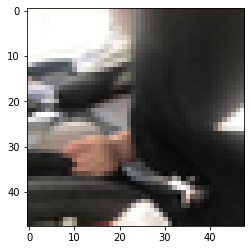

tb: 1; pb: 0.8
body: [-0. -0. 32. 40.]


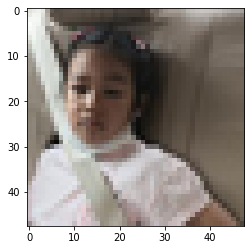

tb: 1; pb: 0.9
body: [ 1.  3. 46. 49.]


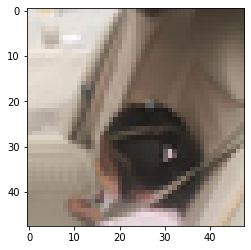

tb: 1; pb: 0.4
body: [ 8. 18. 33. 39.]


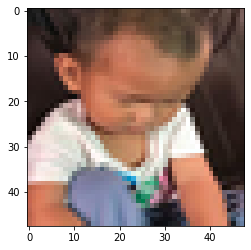

tb: 1; pb: 0.9
body: [ 1.  0. 48. 49.]


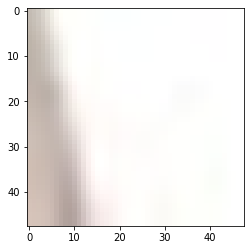

tb: 0; pb: 0.0
body: [ 0. -0. -0. -0.]


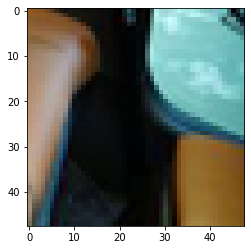

tb: 0; pb: 0.0
body: [-0. -0. -0.  0.]


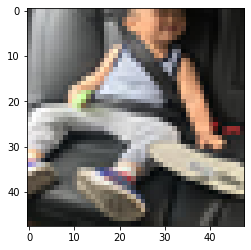

tb: 1; pb: 0.9
body: [ 7.  0. 44. 34.]


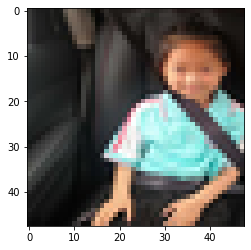

tb: 1; pb: 0.9
body: [14.  2. 49. 48.]


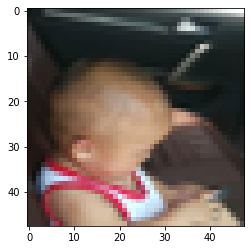

tb: 1; pb: 0.9
body: [ 1. 10. 42. 48.]


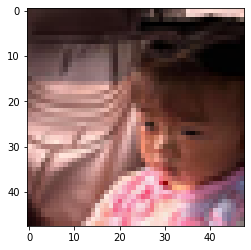

tb: 1; pb: 0.9
body: [-0.  2. 49. 48.]


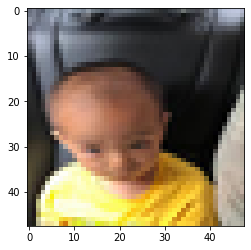

tb: 1; pb: 0.9
body: [ 1.  9. 44. 49.]


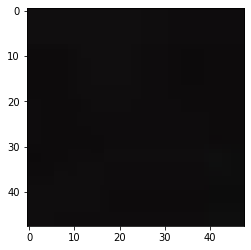

tb: 0; pb: 0.0
body: [0. 0. 0. 0.]


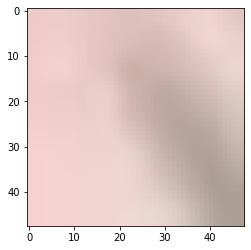

tb: 0; pb: 0.0
body: [ 0.  0. -0.  0.]


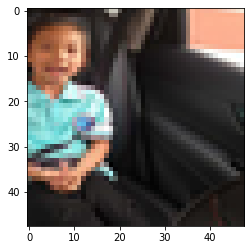

tb: 1; pb: 0.7
body: [ 1.  2. 22. 40.]


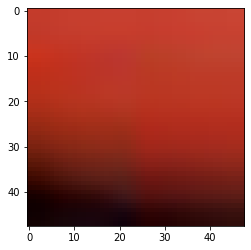

tb: 0; pb: 0.0
body: [0. 0. 0. 0.]


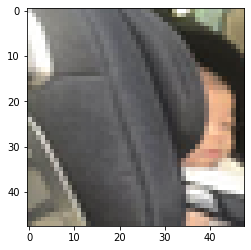

tb: 1; pb: 0.7
body: [27.  9. 48. 47.]


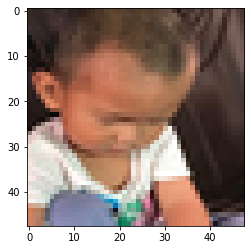

tb: 1; pb: 0.9
body: [ 1.  2. 46. 48.]


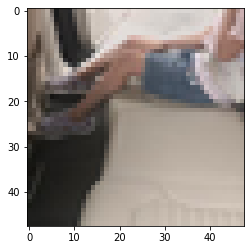

tb: 1; pb: 0.6
body: [23. -0. 51. 23.]


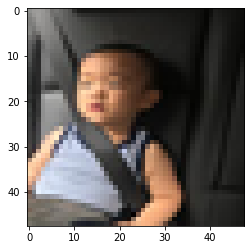

tb: 1; pb: 0.9
body: [-0.  6. 36. 48.]


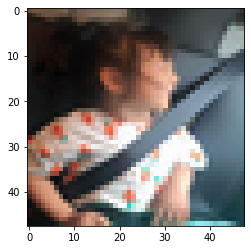

tb: 1; pb: 0.9
body: [ 0.  3. 40. 49.]


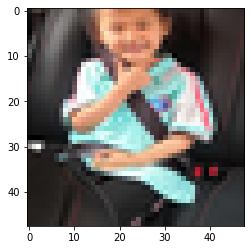

tb: 1; pb: 0.9
body: [ 8.  0. 41. 39.]


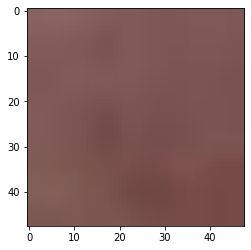

tb: 0; pb: 0.0
body: [ 0. -0. -0.  0.]


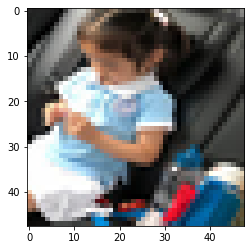

tb: 1; pb: 0.9
body: [ 1.  0. 36. 43.]


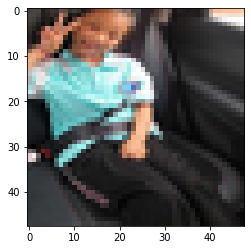

tb: 1; pb: 0.7
body: [ 1.  1. 28. 33.]


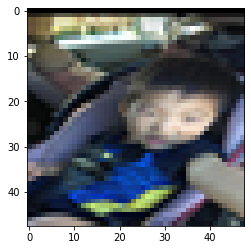

tb: 1; pb: 0.9
body: [ 2.  9. 47. 47.]


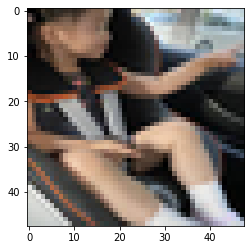

tb: 1; pb: 0.9
body: [-1.  1. 46. 38.]


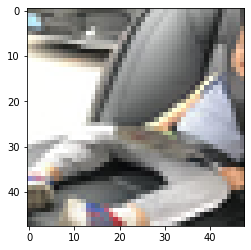

tb: 1; pb: 0.8
body: [23.  1. 49. 43.]


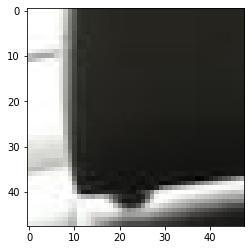

tb: 0; pb: 0.0
body: [0. 0. 0. 0.]


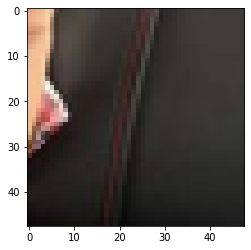

tb: 0; pb: 0.0
body: [ 0.  0.  1. -0.]


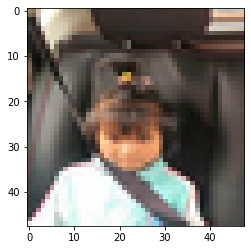

tb: 1; pb: 0.9
body: [ 0. 15. 42. 48.]


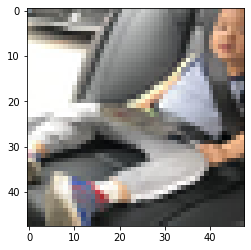

tb: 1; pb: 0.8
body: [21. -0. 48. 35.]


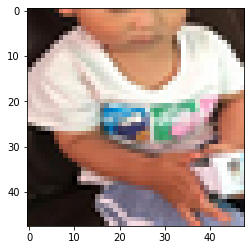

tb: 1; pb: 0.9
body: [ 1.  0. 49. 47.]


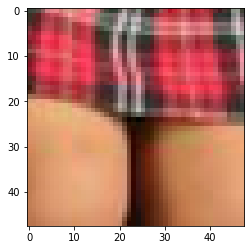

tb: 0; pb: 0.0
body: [ 0. -0.  1.  0.]


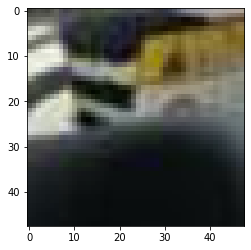

tb: 0; pb: 0.0
body: [0. 0. 0. 0.]


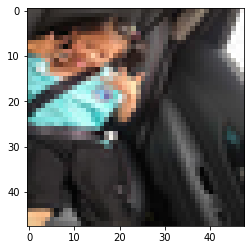

tb: 1; pb: 0.8
body: [ 1.  1. 30. 34.]


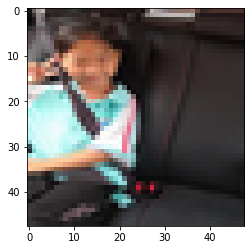

tb: 1; pb: 0.8
body: [ 0.  2. 25. 42.]


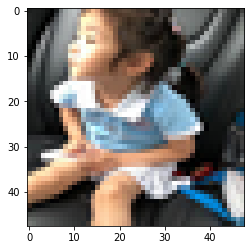

tb: 1; pb: 0.9
body: [ 1.  1. 39. 41.]


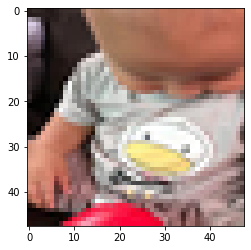

tb: 1; pb: 0.9
body: [-0.  0. 48. 49.]


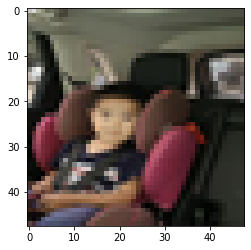

tb: 1; pb: 0.8
body: [ 1. 15. 31. 48.]


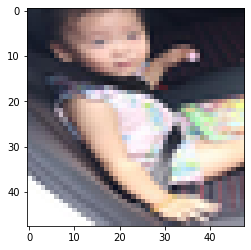

tb: 1; pb: 0.9
body: [ 1. -0. 46. 44.]


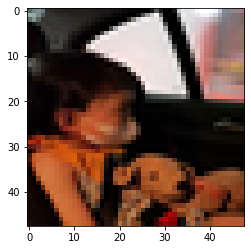

tb: 1; pb: 0.9
body: [ 0.  6. 45. 49.]


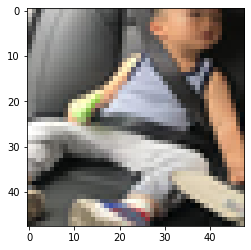

tb: 1; pb: 0.9
body: [ 9.  0. 49. 40.]


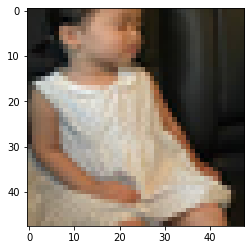

tb: 1; pb: 0.9
body: [-0. -0. 43. 48.]


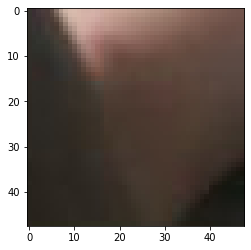

tb: 0; pb: 0.0
body: [ 0.  0.  0. -0.]


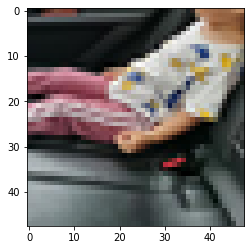

tb: 1; pb: 0.9
body: [12. -0. 47. 34.]


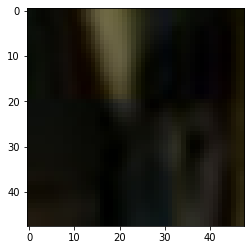

tb: 0; pb: 0.0
body: [0. 0. 0. 0.]


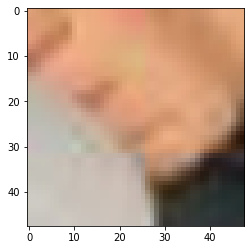

tb: 0; pb: 0.0
body: [ 0.  0. -0.  0.]


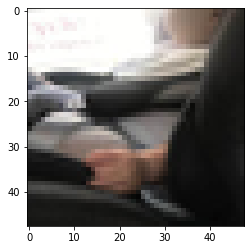

tb: 1; pb: 0.9
body: [ 2.  1. 45. 44.]


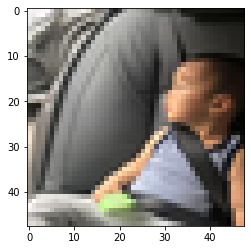

tb: 1; pb: 0.9
body: [14.  9. 48. 49.]


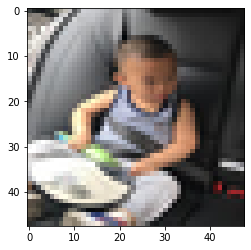

tb: 1; pb: 0.9
body: [ 7.  6. 42. 40.]


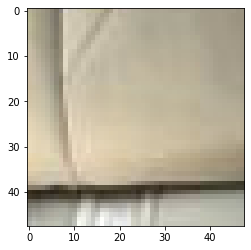

tb: 0; pb: 0.0
body: [ 0. -0.  0.  0.]


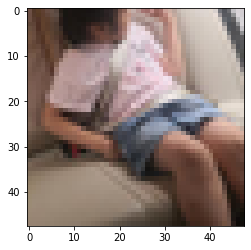

tb: 1; pb: 0.9
body: [ 2. -0. 40. 38.]


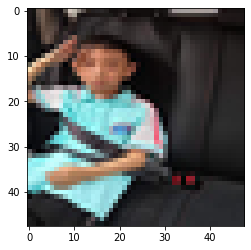

tb: 1; pb: 0.9
body: [-0.  4. 29. 45.]


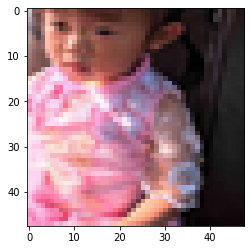

tb: 1; pb: 0.9
body: [-1. -0. 41. 48.]


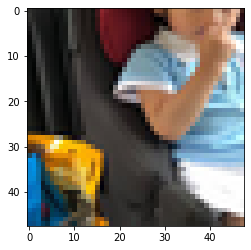

tb: 1; pb: 0.8
body: [17. -0. 49. 36.]


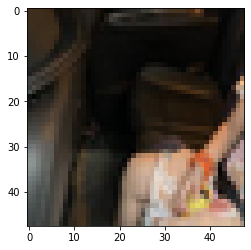

tb: 1; pb: 0.7
body: [20.  4. 46. 47.]


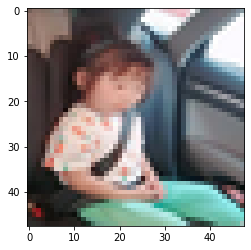

tb: 1; pb: 0.9
body: [ 1.  5. 36. 47.]


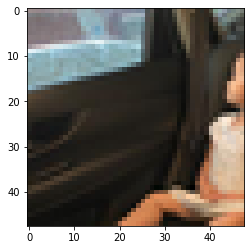

tb: 1; pb: 0.5
body: [37.  6. 45. 43.]


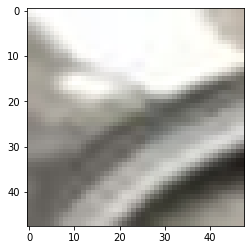

tb: 0; pb: 0.0
body: [ 0.  0. -0. -0.]


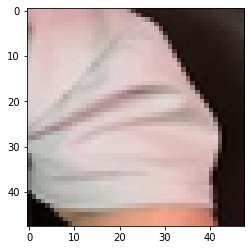

tb: 0; pb: 0.0
body: [ 0.  0. -0. -0.]


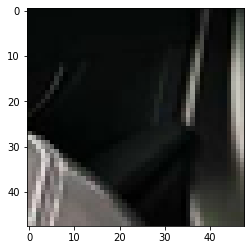

tb: 0; pb: 0.0
body: [ 0.  0.  0. -0.]


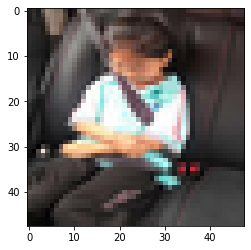

tb: 1; pb: 0.9
body: [ 6.  1. 37. 37.]


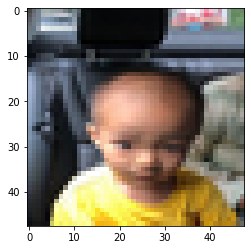

tb: 1; pb: 0.9
body: [ 5. 14. 47. 49.]


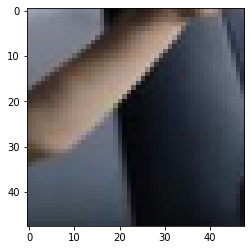

tb: 0; pb: 0.0
body: [ 0. -0. -0.  0.]


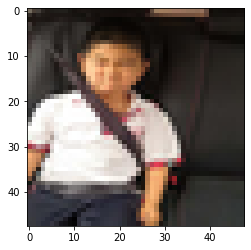

tb: 1; pb: 0.9
body: [-0.  1. 33. 49.]


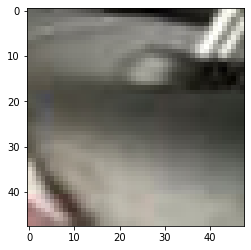

tb: 0; pb: 0.0
body: [ 0. -0.  0.  0.]


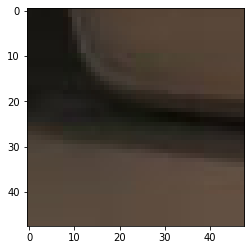

tb: 0; pb: 0.0
body: [ 0. -0. -0.  0.]


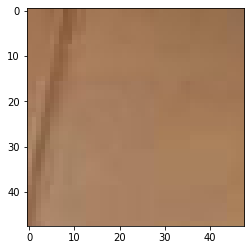

tb: 0; pb: 0.0
body: [-0.  0. -0.  0.]


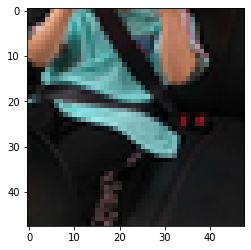

tb: 1; pb: 0.8
body: [ 2.  0. 44. 22.]


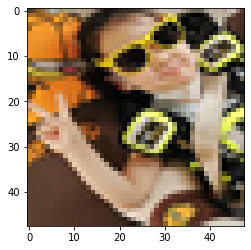

tb: 1; pb: 0.9
body: [ 7. -0. 48. 45.]


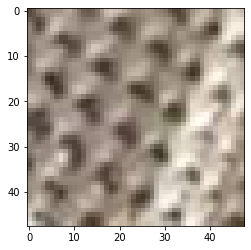

tb: 0; pb: 0.0
body: [-0.  0. -0.  0.]


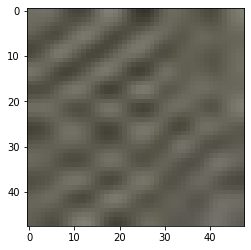

tb: 0; pb: 0.0
body: [ 0. -0. -0. -0.]


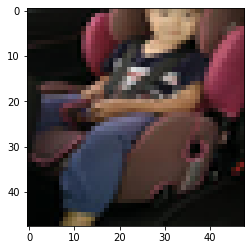

tb: 1; pb: 0.9
body: [ 1.  0. 44. 38.]


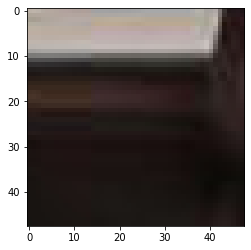

tb: 0; pb: 0.0
body: [ 0.  0.  0. -0.]


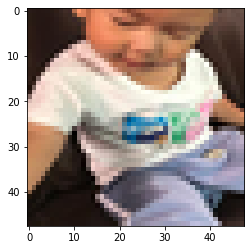

tb: 1; pb: 0.9
body: [-1.  0. 48. 49.]


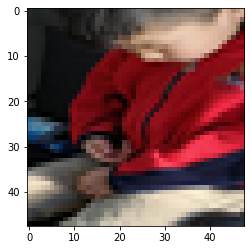

tb: 1; pb: 0.9
body: [ 2. -1. 48. 47.]


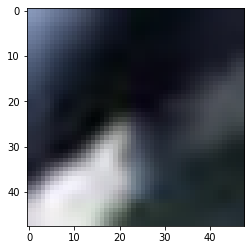

tb: 0; pb: 0.0
body: [-0. -0. -0.  0.]


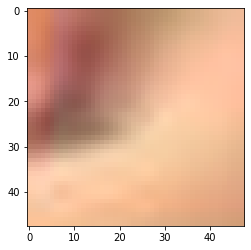

tb: 0; pb: 0.0
body: [-0.  0. -0.  0.]


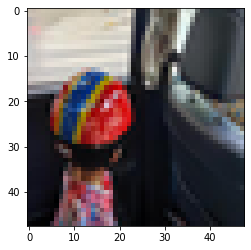

tb: 1; pb: 0.8
body: [ 1. 13. 26. 51.]


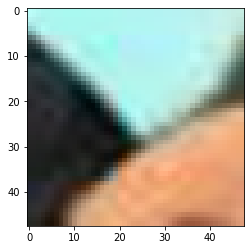

tb: 0; pb: 0.0
body: [ 0.  0. -0.  0.]


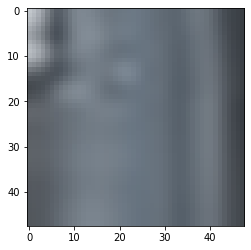

tb: 0; pb: 0.0
body: [ 0. -0. -0.  0.]


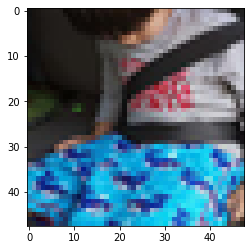

tb: 1; pb: 0.9
body: [ 5. -1. 50. 49.]


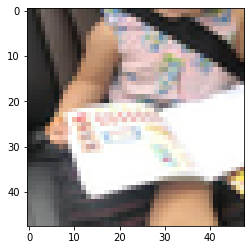

tb: 1; pb: 0.9
body: [ 4.  0. 42. 29.]


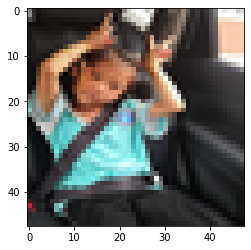

tb: 1; pb: 0.9
body: [ 0. -1. 36. 36.]


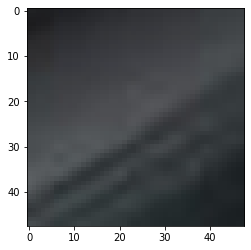

tb: 0; pb: 0.0
body: [ 0. -0. -0.  0.]


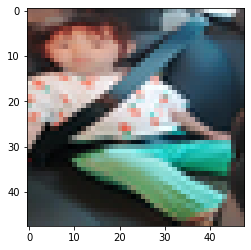

tb: 1; pb: 0.9
body: [-1.  0. 46. 39.]


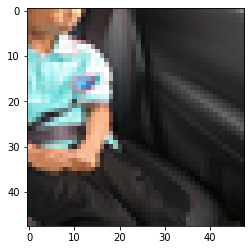

tb: 1; pb: 0.7
body: [ 1. -1. 21. 41.]


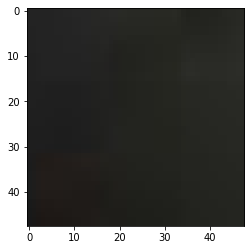

tb: 0; pb: 0.0
body: [ 0. -0. -0.  0.]


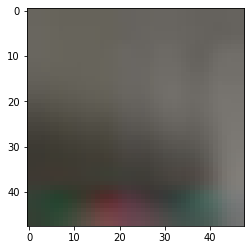

tb: 0; pb: 0.0
body: [ 0. -0. -0.  0.]


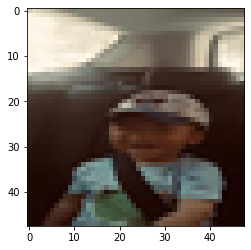

tb: 1; pb: 0.8
body: [ 2. 18. 43. 47.]


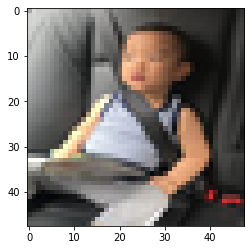

tb: 1; pb: 0.9
body: [ 3.  3. 42. 44.]


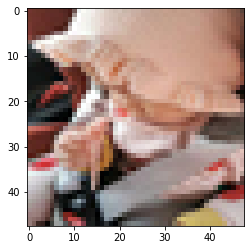

tb: 1; pb: 0.9
body: [-1.  0. 50. 49.]


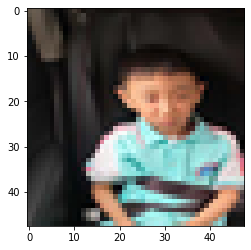

tb: 1; pb: 0.9
body: [11.  8. 49. 49.]


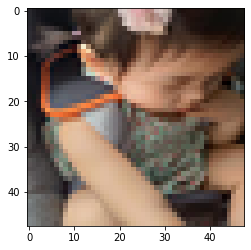

tb: 1; pb: 0.9
body: [ 1. -0. 47. 49.]


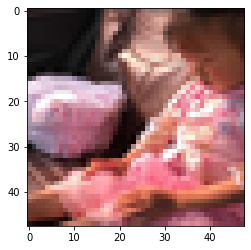

tb: 1; pb: 0.9
body: [ 9.  0. 48. 48.]


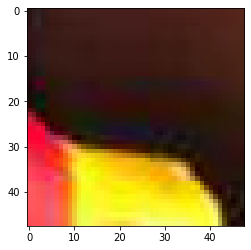

tb: 0; pb: 0.0
body: [ 0. -0. -1. -1.]


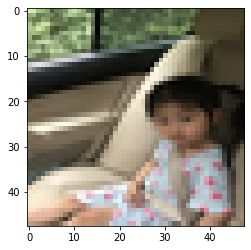

tb: 1; pb: 0.8
body: [19. 15. 47. 48.]


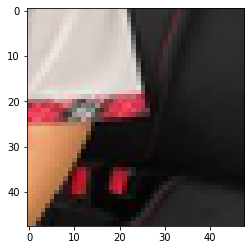

tb: 0; pb: 0.0
body: [ 0. -0.  1. -1.]


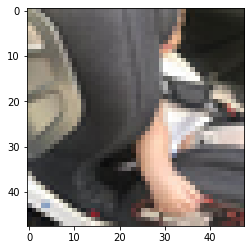

tb: 1; pb: 0.9
body: [20. -0. 50. 49.]


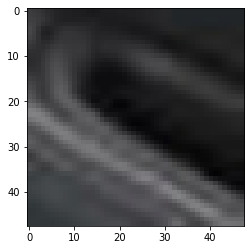

tb: 0; pb: 0.0
body: [ 0. -0.  0.  0.]


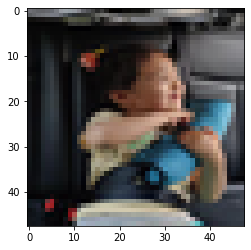

tb: 1; pb: 0.9
body: [11.  9. 47. 48.]


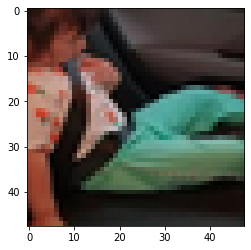

tb: 1; pb: 0.8
body: [ 1.  1. 27. 45.]


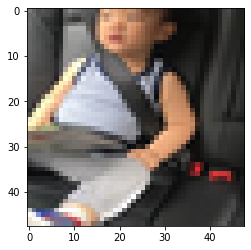

tb: 1; pb: 0.9
body: [-0. -0. 40. 38.]


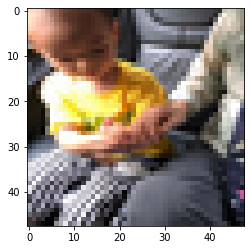

tb: 1; pb: 0.8
body: [-2.  0. 31. 35.]


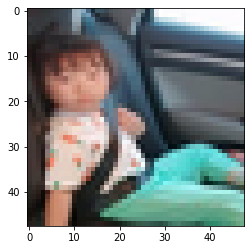

tb: 1; pb: 0.8
body: [-0.  1. 30. 45.]


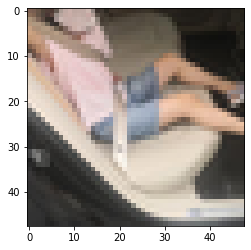

tb: 1; pb: 0.7
body: [ 3.  0. 33. 30.]


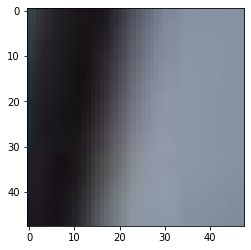

tb: 0; pb: 0.0
body: [ 0. -0. -0.  0.]


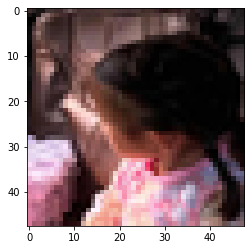

tb: 1; pb: 0.9
body: [ 0.  6. 49. 48.]
total: 7505
body accuracy: 99.5%


In [13]:
total = len(valid_ds)
b_err = 0
bt, bp = [], []

for idx in range(0, total):
    
    obp, obb = bnet(valid_ds[idx][0].unsqueeze(0).to(device))
    obp = obp.squeeze()
    
    aop = obp[0]
    obp = int(obp[0] > obp[1])

    tbp = int(b_prob_v[idx][0] > b_prob_v[idx][1])

    b_err += (obp != tbp)
        
    if idx % 20 == 0:
        plt.imshow(transforms.ToPILImage()(valid_ds[idx][0]))
        plt.show()
        print("tb: {}; pb: {:.1f}".format(int(tbp), aop.cpu().detach().item()))
        print("body: " + str(np.rint(obb.cpu().detach().squeeze().numpy())))

print("total: {}".format(total))
print("body accuracy: {:.1f}%".format(100*(total-b_err)/total))

"""
p, r, f1 = utils.f1_score(truth, pred, 0)
print("precision: {:.2f}, recall: {:.2f}, f1: {:.2f}".format(p, r, f1))
print("valid_ds length: {}".format(len(valid_ds)))
print("age dist: ", end='')
""";

In [ ]:
save_name = 'bnet.pt'
torch.save(bnet.state_dict(), save_name)
print('Saved model at {}'.format(save_name))